## Multinomial Naive Bayes with Count Vectorizer -- part two.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_colwidth = 1800
from pathlib import Path
import seaborn as sns
sns.set()
import plotly.express as px
from itertools import combinations
from scipy.special import comb
from IPython.display import IFrame


#Sklearn 
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,CategoricalNB



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import pymongo
from pymongo import MongoClient
import json
import dns


In [2]:
import sys
sys.path.append('./assets/')
from myStoppyStoppers import expl_list
from myStoppyStoppers import extra_stop_words

In [3]:
history_test = pd.DataFrame()

## How does it work?

**Overview of what is taking place**
1. designate the file
2. clear out index and set up the four classifiers
3. convert all artists to a list
4. return the dataframe

In [4]:
name=os.listdir('./data/')[0]
file='./data/'+name
#These variables will be the first file in the directory this is only for demo 
#later in the bottom we will simply use Path.Glob


#This function brings in the csv from a directory filepath combo. There is no specificity so it will 
#bring in anything and everything make sure these are all csvs with the index still on or modify 
#the code so that it reflects accordingly
def openfile(a):
    df=pd.read_csv(a, index_col=False)
    df.drop(columns=('Unnamed: 0'), inplace=True)
    return df

df=openfile(file)
#save it to a variable for examination

In [5]:
df.sample(10)

,artist,text
8589,Drake,Tell me when Im lyin tell me when Im tryin
5376,Action Bronson,I want the from Ocky but he fronted
8480,Drake,We even gave yall the whole money play and yall broke to this day
725,A$AP Ant,Diamonds so cold he from Denver
6042,Action Bronson,Am I gonna sell my soul That depends ho
8073,Drake,Guess she dont have the time to kick it no more
1776,A$AP Rocky,Kurt Cobain even died cause you scrutinize
4563,Action Bronson,The finest vaginas demolished by my dick
1886,A$AP Rocky,Equipped with a gat and the dick in your mouth
1002,A$AP Ant,Dj Nick son bro we came lit


**Overview of what is taking place**
1. get_list -- The first function gives us our targets in array form
2. def dataframe_deets-- For our purposes here we will do a bit of sanity check to make sure what we have is what we want. These are just some essential details that will help shed insight on what we actually are dealing with.

In [6]:
def get_list(a):
    rappers=a.artist.unique().tolist()
    return rappers
thrappers=get_list(df)


def dataframe_deets(a):
    meow=a.unique().tolist()
    sizecheck=a.shape[0]
    meowmeow=a.value_counts()
    print(f'check to see who the targets are: {meow} \
        \n\nthe file is {sizecheck} rows long.\n\nHere are the value counts:\n{meowmeow}')

dataframe_deets(df.artist)

check to see who the targets are: ['A$AP Ant', 'A$AP Rocky', 'Action Bronson', 'Drake']         

the file is 10130 rows long.

Here are the value counts:
Drake             3210
A$AP Rocky        3181
Action Bronson    2631
A$AP Ant          1108
Name: artist, dtype: int64


**Overview of what is taking place**
Because artist could be a word in the lyrics we will call them floggityflog

In [7]:
def prepit(a):
    #a = np.where(a == target_string, 1, 0)
    df.rename(columns={'artist': 'floggityflog'}, inplace=True)
prepit(df['artist'])

In [8]:
df.head()

,floggityflog,text
0,A$AP Ant,Triple beam for the weight
1,A$AP Ant,Cut the middle man tryna get white bitches
2,A$AP Ant,Snorting off the plate coke from Colombia
3,A$AP Ant,Riding round in the Benz looking like a trap star
4,A$AP Ant,Flipping raw day and night


**Overview**

In our first attempt to work with multiple classes, the first model we will try out is the Multinomial Naive Bayes. Again sticking wit speed and the fact that it really gives quick predictions this seemed like a good first step. 

In relation to the text data here we have selected Count Vectorizer as our tokenizer. TfidfVectorizer() assigns a score while CountVectorizer() counts and after careful evaluation of both. I decided to go with Count Vecortizer you can easily modify this. Simply this is a bag of words that we have delimited ourselves for profanity and the highly reoccuring terms.

In [9]:
def gridsearchy(a,b):
    my_stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)
    X = df['text'] 
    y = df['floggityflog']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)
    cvec = CountVectorizer(stop_words=my_stop_words)
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('mnb', MultinomialNB())
    ])

    pipe_params = {
        'cvec__max_features': [1_500, 5_000, 12_000, 20_000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [.9, .95],
        'cvec__ngram_range': [(1,1), (1,2),(2,2)],
        'mnb__alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        'mnb__fit_prior':[True, False]
    }
    gs = GridSearchCV(pipe, 
                      param_grid=pipe_params, 
                      cv=5) 
    gs.fit(X_train, y_train)
    bestparms=gs.best_params_
    return bestparms

In [10]:
bestparamies=gridsearchy(df['text'],df['floggityflog'])
bestparamies

{'cvec__max_df': 0.9,
 'cvec__max_features': 12000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'mnb__alpha': 1.0,
 'mnb__fit_prior': True}

**Overview**

We have our stop words in a py file. It just is annoying to look at a big list so organizing it somewhere for later use is just a good idea. So now that we have our best params we can simply pass it to the model and get our classification report that we will out put as a dictionary to convert to our preliminary dataframe. 

In [11]:
extra_stop_words=expl_list+extra_stop_words
my_stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

In [12]:
def run_mod(a,b,c):
    X = a
    y = b
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)
    cvec = CountVectorizer(stop_words=my_stop_words)
    bnb = BernoulliNB()
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('mnb', MultinomialNB())
    ])
    pipe_params = c
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return classification_report(y_test,preds, output_dict=True)

In [13]:
new_report=run_mod(df['text'],df['floggityflog'],bestparamies)
one = pd.DataFrame(new_report).transpose()
one

,precision,recall,f1-score,support
A$AP Ant,0.807143,0.308743,0.446640,366.000000
A$AP Rocky,0.577957,0.614286,0.595568,1050.000000
Action Bronson,0.708018,0.539171,0.612165,868.000000
Drake,0.582048,0.783758,0.668008,1059.000000
accuracy,0.615016,0.615016,0.615016,0.615016
macro avg,0.668791,0.561489,0.580595,3343.000000
weighted avg,0.638115,0.615016,0.606520,3343.000000


This could be done as dictionary but honestly it is easier to use loc to figure out what you want and what to leave behind. Plus it offers no help in this instance when you want people to visualize what was actually produced. 

In [14]:
def results(a):
    rapper_one=a['precision'].iloc[0]
    rapper_two=a['precision'].iloc[1]
    rapper_three=a['precision'].iloc[2]
    rapper_four=a['precision'].iloc[3]
    accuracy=a['precision'].iloc[2]
    dicty={'first_rapper':thrappers[0],
           'first_score':rapper_one,
           'second_rapper':thrappers[1],
           'second_score':rapper_two,
           'third_rapper':thrappers[2],
           'third_score':rapper_three,
           'fourth_rapper':thrappers[3],
           'fourth_score':rapper_four,
           'accuracy':accuracy,
           'testing':thrappers[0]+","+thrappers[1]+","+thrappers[2]+","+thrappers[3]}
    return dicty

one_dict=results(one)

**Now just append it to our empty dataframe and we have our first test subject.** This should have clarified what we are doing. 

In [15]:
history_test = history_test.append(one_dict, ignore_index=True)
history_test

,accuracy,first_rapper,first_score,fourth_rapper,fourth_score,second_rapper,second_score,testing,third_rapper,third_score
0,0.708018,A$AP Ant,0.807143,Drake,0.582048,A$AP Rocky,0.577957,"A$AP Ant,A$AP Rocky,Action Bronson,Drake",Action Bronson,0.708018


## Lets Do Them All!

This function is literally everything above in a simple for loop using Path.glob('*'). This means that anything in the directory is going to be subject to the function make sure that the directory is clear of anything but files that are formatted for the process.

In [16]:
#We can iterate over files in a directory using Path.glob() function which glob the specified pattern in the given directory and yields the matching files.
#Path.glob(‘*’) yield all the files in the given directory
#modified from: https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
history = pd.DataFrame()

directory = './data/'
files = Path(directory).glob('*')
for each in files:
    df=openfile(each)    
    thrappers=get_list(df)
    prepit(df['artist'])
    new_report=run_mod(df['text'],df['floggityflog'],bestparamies)
    each = pd.DataFrame(new_report).transpose()
    each=results(each)
    history = history.append(each, ignore_index=True)
    print(each)

{'first_rapper': 'A$AP Ant', 'first_score': 0.8071428571428572, 'second_rapper': 'A$AP Rocky', 'second_score': 0.5779569892473119, 'third_rapper': 'Action Bronson', 'third_score': 0.708018154311649, 'fourth_rapper': 'Drake', 'fourth_score': 0.5820476858345021, 'accuracy': 0.708018154311649, 'testing': 'A$AP Ant,A$AP Rocky,Action Bronson,Drake'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.875, 'second_rapper': 'A$AP Rocky', 'second_score': 0.8269230769230769, 'third_rapper': 'Big L', 'third_score': 0.6901669758812616, 'fourth_rapper': '2pac', 'fourth_score': 0.7446949602122016, 'accuracy': 0.6901669758812616, 'testing': 'A$AP Ant,A$AP Rocky,Big L,2pac'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8536585365853658, 'second_rapper': 'A$AP Rocky', 'second_score': 0.5814376706096451, 'third_rapper': 'Big L', 'third_score': 0.6625842008573178, 'fourth_rapper': 'Chance The Rapper', 'fourth_score': 0.6662763466042154, 'accuracy': 0.6625842008573178, 'testing': 'A$AP Ant,A$AP Rocky,Big L,Ch

{'first_rapper': 'A$AP Ant', 'first_score': 0.7819548872180451, 'second_rapper': 'A$AP Rocky', 'second_score': 0.6022628372497825, 'third_rapper': 'NF', 'third_score': 0.6438450899031812, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6842767295597484, 'accuracy': 0.6438450899031812, 'testing': 'A$AP Ant,A$AP Rocky,NF,Pusha-T'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8914285714285715, 'second_rapper': 'Action Bronson', 'second_score': 0.6973684210526315, 'third_rapper': 'André 3000', 'third_score': 0.8823529411764706, 'fourth_rapper': 'Immortal Technique', 'fourth_score': 0.717391304347826, 'accuracy': 0.8823529411764706, 'testing': 'A$AP Ant,Action Bronson,André 3000,Immortal Technique'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8716216216216216, 'second_rapper': 'Action Bronson', 'second_score': 0.625170998632011, 'third_rapper': 'Bas', 'third_score': 0.5735694822888283, 'fourth_rapper': 'Nas', 'fourth_score': 0.5928725701943844, 'accuracy': 0.5735694822888283, 'testing': 'A

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'A$AP Ant', 'first_score': 0.8538011695906432, 'second_rapper': 'Action Bronson', 'second_score': 0.7537993920972644, 'third_rapper': 'Logic', 'third_score': 0.7178649237472767, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.7178649237472767, 'testing': 'A$AP Ant,Action Bronson,Logic,missyelliott'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8549618320610687, 'second_rapper': 'Action Bronson', 'second_score': 0.5965732087227414, 'third_rapper': 'Mac Miller', 'third_score': 0.5383469843633656, 'fourth_rapper': 'Nas', 'fourth_score': 0.6138059701492538, 'accuracy': 0.5383469843633656, 'testing': 'A$AP Ant,Action Bronson,Mac Miller,Nas'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.9433962264150944, 'second_rapper': 'Action Bronson', 'second_score': 0.7796610169491526, 'third_rapper': 'Montana of 300', 'third_score': 0.6843800322061192, 'fourth_rapper': 'NF', 'fourth_score': 0.710077519379845, 'accuracy': 0.6843800322061192, 'testing': 'A$AP Ant,Ac

{'first_rapper': 'A$AP Ant', 'first_score': 0.8345323741007195, 'second_rapper': 'Bas', 'second_score': 0.6140776699029126, 'third_rapper': 'Eminem', 'third_score': 0.6286953094205755, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.581293157564344, 'accuracy': 0.6286953094205755, 'testing': 'A$AP Ant,Bas,Eminem,Kendrick Lamar'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8785714285714286, 'second_rapper': 'Bas', 'second_score': 0.591337099811676, 'third_rapper': 'Ice Cube', 'third_score': 0.6191126279863481, 'fourth_rapper': 'Joey Bada', 'fourth_score': 0.5606536769327467, 'accuracy': 0.6191126279863481, 'testing': 'A$AP Ant,Bas,Ice Cube,Joey Bada'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.868421052631579, 'second_rapper': 'Bas', 'second_score': 0.5651340996168582, 'third_rapper': 'Lil Wayne', 'third_score': 0.556271981242673, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.6463022508038585, 'accuracy': 0.556271981242673, 'testing': 'A$AP Ant,Bas,Lil Wayne,Lupe Fiasco'}


{'first_rapper': 'A$AP Ant', 'first_score': 0.5862068965517241, 'second_rapper': 'Chance The Rapper', 'second_score': 0.78125, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.6383476227591582, 'fourth_rapper': '2pac', 'fourth_score': 0.648, 'accuracy': 0.6383476227591582, 'testing': 'A$AP Ant,Chance The Rapper,Earl Sweatshirt,2pac'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8431372549019608, 'second_rapper': 'Chance The Rapper', 'second_score': 0.5658783783783784, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.6016597510373444, 'fourth_rapper': 'Immortal Technique', 'fourth_score': 0.6824769433465085, 'accuracy': 0.6016597510373444, 'testing': 'A$AP Ant,Chance The Rapper,Earl Sweatshirt,Immortal Technique'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8051948051948052, 'second_rapper': 'Chance The Rapper', 'second_score': 0.55625, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.5617529880478087, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5155358275206088, 'accur

{'first_rapper': 'A$AP Ant', 'first_score': 0.8857142857142857, 'second_rapper': 'Common', 'second_score': 0.6179245283018868, 'third_rapper': 'Immortal Technique', 'third_score': 0.7125097125097125, 'fourth_rapper': 'dmx', 'fourth_score': 0.5294117647058824, 'accuracy': 0.7125097125097125, 'testing': 'A$AP Ant,Common,Immortal Technique,dmx'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.9136690647482014, 'second_rapper': 'Common', 'second_score': 0.5201754385964912, 'third_rapper': 'Jay-z', 'third_score': 0.5268630849220104, 'fourth_rapper': 'Joey Bada', 'fourth_score': 0.5056628914057295, 'accuracy': 0.5268630849220104, 'testing': 'A$AP Ant,Common,Jay-z,Joey Bada'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8841463414634146, 'second_rapper': 'Common', 'second_score': 0.6353413654618474, 'third_rapper': 'Jay-z', 'third_score': 0.6387147335423198, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6387147335423198, 'testing': 'A$AP Ant,Common,Jay-z,missyelliott'}
{'

{'first_rapper': 'A$AP Ant', 'first_score': 0.8944099378881988, 'second_rapper': 'CunninLynguists', 'second_score': 0.7063253012048193, 'third_rapper': 'Scarface', 'third_score': 0.6026711185308848, 'fourth_rapper': 'cardib', 'fourth_score': 0.7142857142857143, 'accuracy': 0.6026711185308848, 'testing': 'A$AP Ant,CunninLynguists,Scarface,cardib'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.9090909090909091, 'second_rapper': 'Deniro Farrar', 'second_score': 0.596340150699677, 'third_rapper': 'Eazy-E', 'third_score': 0.7194244604316546, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6227979274611399, 'accuracy': 0.7194244604316546, 'testing': 'A$AP Ant,Deniro Farrar,Eazy-E,Montana of 300'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.9097222222222222, 'second_rapper': 'Deniro Farrar', 'second_score': 0.6437598736176935, 'third_rapper': 'Immortal Technique', 'third_score': 0.8284518828451883, 'fourth_rapper': 'cardib', 'fourth_score': 0.6666666666666666, 'accuracy': 0.82845188284

{'first_rapper': 'A$AP Ant', 'first_score': 0.875, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.7239819004524887, 'third_rapper': 'Scarface', 'third_score': 0.6682001150086256, 'fourth_rapper': 'cardib', 'fourth_score': 0.8571428571428571, 'accuracy': 0.6682001150086256, 'testing': 'A$AP Ant,Earl Sweatshirt,Scarface,cardib'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.852112676056338, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6816816816816816, 'third_rapper': 'Scarface', 'third_score': 0.5427940364439536, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6150234741784038, 'accuracy': 0.5427940364439536, 'testing': 'A$AP Ant,Earl Sweatshirt,Scarface,Talib Kweli'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.9, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6884735202492211, 'third_rapper': 'Scarface', 'third_score': 0.5659062103929025, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.5933068633011912, 'accuracy': 0.5659062103929025, 'testing': 'A$AP

{'first_rapper': 'A$AP Ant', 'first_score': 0.8658536585365854, 'second_rapper': 'Immortal Technique', 'second_score': 0.7255563047875927, 'third_rapper': 'Pusha-T', 'third_score': 0.6876208897485493, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6876208897485493, 'testing': 'A$AP Ant,Immortal Technique,Pusha-T,missyelliott'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8952380952380953, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6230769230769231, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.6522511848341233, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.631413612565445, 'accuracy': 0.6522511848341233, 'testing': 'A$AP Ant,Isaiah Rashad,Kendrick Lamar,Montana of 300'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.908256880733945, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6630434782608695, 'third_rapper': 'Montana of 300', 'third_score': 0.6246231155778894, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.688, 'accuracy': 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'A$AP Ant', 'first_score': 0.8282208588957055, 'second_rapper': 'J Cole', 'second_score': 0.6729368932038835, 'third_rapper': 'Tyler The Creator', 'third_score': 0.7406049495875344, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.7406049495875344, 'testing': 'A$AP Ant,J Cole,Tyler The Creator,missyelliott'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8507462686567164, 'second_rapper': 'Joey Bada', 'second_score': 0.5643185298621746, 'third_rapper': 'Kanye West', 'third_score': 0.5570079883805374, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5446265938069217, 'accuracy': 0.5570079883805374, 'testing': 'A$AP Ant,Joey Bada,Kanye West,Mac Miller'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.8768115942028986, 'second_rapper': 'Joey Bada', 'second_score': 0.5929824561403508, 'third_rapper': 'Kanye West', 'third_score': 0.5885714285714285, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5445161290322581, 'accuracy': 0.5885714285714285, 'testing': 'A

{'first_rapper': 'A$AP Ant', 'first_score': 0.9183673469387755, 'second_rapper': 'Lupe Fiasco', 'second_score': 0.6482701812191104, 'third_rapper': 'Montana of 300', 'third_score': 0.5901725039205437, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5645161290322581, 'accuracy': 0.5901725039205437, 'testing': 'A$AP Ant,Lupe Fiasco,Montana of 300,Royce Da 59'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.7142857142857143, 'second_rapper': 'Mac Miller', 'second_score': 0.88, 'third_rapper': '2pac', 'third_score': 0.8319132455460883, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.8319132455460883, 'testing': 'A$AP Ant,Mac Miller,2pac,missyelliott'}
{'first_rapper': 'A$AP Ant', 'first_score': 0.7888198757763976, 'second_rapper': 'Mac Miller', 'second_score': 0.6336791699920191, 'third_rapper': 'Nas', 'third_score': 0.7134986225895317, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7134986225895317, 'testing': 'A$AP Ant,Mac Miller,Nas,missyelliott

{'first_rapper': 'A$AP Rocky', 'first_score': 0.5467565290648694, 'second_rapper': 'Action Bronson', 'second_score': 0.6429872495446266, 'third_rapper': 'Pusha-T', 'third_score': 0.5852760736196319, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5429782082324455, 'accuracy': 0.5852760736196319, 'testing': 'A$AP Rocky,Action Bronson,Pusha-T,Tyler The Creator'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.625139043381535, 'second_rapper': 'Action Bronson', 'second_score': 0.703125, 'third_rapper': 'Scarface', 'third_score': 0.512998266897747, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5860953920776071, 'accuracy': 0.512998266897747, 'testing': 'A$AP Rocky,Action Bronson,Scarface,Talib Kweli'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.7142857142857143, 'second_rapper': 'Action Bronson', 'second_score': 0.6305732484076433, 'third_rapper': 'Tyler The Creator', 'third_score': 0.709731543624161, 'fourth_rapper': '2pac', 'fourth_score': 0.6315431679129844, 'accuracy': 

{'first_rapper': 'A$AP Rocky', 'first_score': 0.5730569948186528, 'second_rapper': 'Bas', 'second_score': 0.6, 'third_rapper': 'Childish Gambino', 'third_score': 0.5653679653679654, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5367987647967061, 'accuracy': 0.5653679653679654, 'testing': 'A$AP Rocky,Bas,Childish Gambino,Royce Da 59'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.8333333333333334, 'second_rapper': 'Bas', 'second_score': 0.6384015594541911, 'third_rapper': 'Drake', 'third_score': 0.6534839924670434, 'fourth_rapper': '2pac', 'fourth_score': 0.5811001410437235, 'accuracy': 0.6534839924670434, 'testing': 'A$AP Rocky,Bas,Drake,2pac'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6172022684310019, 'second_rapper': 'Bas', 'second_score': 0.665314401622718, 'third_rapper': 'Drake', 'third_score': 0.573758865248227, 'fourth_rapper': 'dmx', 'fourth_score': 0.9545454545454546, 'accuracy': 0.573758865248227, 'testing': 'A$AP Rocky,Bas,Drake,dmx'}
{'first_rapper': 'A$AP Rock

{'first_rapper': 'A$AP Rocky', 'first_score': 0.6375121477162293, 'second_rapper': 'Big L', 'second_score': 0.7163362952836637, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6260623229461756, 'fourth_rapper': 'dmx', 'fourth_score': 0.875, 'accuracy': 0.6260623229461756, 'testing': 'A$AP Rocky,Big L,Isaiah Rashad,dmx'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6425339366515838, 'second_rapper': 'Big L', 'second_score': 0.7122571001494769, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6712062256809338, 'fourth_rapper': 'NF', 'fourth_score': 0.624246483590087, 'accuracy': 0.6712062256809338, 'testing': 'A$AP Rocky,Big L,Isaiah Rashad,NF'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.7112860892388452, 'second_rapper': 'Big L', 'second_score': 0.7248764415156508, 'third_rapper': 'J Cole', 'third_score': 0.5966981132075472, 'fourth_rapper': 'dmx', 'fourth_score': 0.9333333333333333, 'accuracy': 0.5966981132075472, 'testing': 'A$AP Rocky,Big L,J Cole,dmx'}
{'first_rapper': 'A

{'first_rapper': 'A$AP Rocky', 'first_score': 0.6266944734098019, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6447761194029851, 'third_rapper': 'NF', 'third_score': 0.5866486850977748, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6092050209205021, 'accuracy': 0.5866486850977748, 'testing': 'A$AP Rocky,Chance The Rapper,NF,Talib Kweli'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.5593692022263451, 'second_rapper': 'Childish Gambino', 'second_score': 0.5559030492572322, 'third_rapper': 'Common', 'third_score': 0.5808550185873605, 'fourth_rapper': 'Isaiah Rashad', 'fourth_score': 0.5503048780487805, 'accuracy': 0.5808550185873605, 'testing': 'A$AP Rocky,Childish Gambino,Common,Isaiah Rashad'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.5945683802133851, 'second_rapper': 'Childish Gambino', 'second_score': 0.523102310231023, 'third_rapper': 'CunninLynguists', 'third_score': 0.6300417246175244, 'fourth_rapper': 'Kanye West', 'fourth_score': 0.5183321351545651, 'accu

{'first_rapper': 'A$AP Rocky', 'first_score': 0.5805340223944875, 'second_rapper': 'CunninLynguists', 'second_score': 0.5731981981981982, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.5347985347985348, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5217391304347826, 'accuracy': 0.5347985347985348, 'testing': 'A$AP Rocky,CunninLynguists,Earl Sweatshirt,Tyler The Creator'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6517119244391971, 'second_rapper': 'CunninLynguists', 'second_score': 0.5254629629629629, 'third_rapper': 'Eminem', 'third_score': 0.555671902268761, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5142071494042163, 'accuracy': 0.555671902268761, 'testing': 'A$AP Rocky,CunninLynguists,Eminem,Talib Kweli'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.5407026563838904, 'second_rapper': 'CunninLynguists', 'second_score': 0.5947955390334573, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.533515731874145, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.51806

{'first_rapper': 'A$AP Rocky', 'first_score': 0.635593220338983, 'second_rapper': 'Drake', 'second_score': 0.5682888540031397, 'third_rapper': 'Mac Miller', 'third_score': 0.59, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.75, 'accuracy': 0.59, 'testing': 'A$AP Rocky,Drake,Mac Miller,missyelliott'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.619533527696793, 'second_rapper': 'Drake', 'second_score': 0.5292529252925292, 'third_rapper': 'Montana of 300', 'third_score': 0.581360201511335, 'fourth_rapper': 'Nas', 'fourth_score': 0.6506122448979592, 'accuracy': 0.581360201511335, 'testing': 'A$AP Rocky,Drake,Montana of 300,Nas'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6745562130177515, 'second_rapper': 'Drake', 'second_score': 0.56045197740113, 'third_rapper': 'Montana of 300', 'third_score': 0.6494091164884637, 'fourth_rapper': 'NF', 'fourth_score': 0.6171816126601356, 'accuracy': 0.6494091164884637, 'testing': 'A$AP Rocky,Drake,Montana of 300,NF'}
{'first_rapper': 'A$AP 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'A$AP Rocky', 'first_score': 0.6777493606138107, 'second_rapper': 'Eazy-E', 'second_score': 0.7134268537074149, 'third_rapper': 'Montana of 300', 'third_score': 0.6670229823623731, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6670229823623731, 'testing': 'A$AP Rocky,Eazy-E,Montana of 300,missyelliott'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6316472114137484, 'second_rapper': 'Eminem', 'second_score': 0.5833333333333334, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5511288180610889, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5705128205128205, 'accuracy': 0.5511288180610889, 'testing': 'A$AP Rocky,Eminem,Kendrick Lamar,Talib Kweli'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.7455540355677155, 'second_rapper': 'Eminem', 'second_score': 0.7204556241101091, 'third_rapper': 'Logic', 'third_score': 0.6472065285624607, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6472065285624607, 'testing': 'A$AP Rocky,Eminem,

{'first_rapper': 'A$AP Rocky', 'first_score': 0.5663956639566395, 'second_rapper': 'Jay-z', 'second_score': 0.6012931034482759, 'third_rapper': 'Lil Wayne', 'third_score': 0.5722448979591837, 'fourth_rapper': 'Logic', 'fourth_score': 0.5397672162948594, 'accuracy': 0.5722448979591837, 'testing': 'A$AP Rocky,Jay-z,Lil Wayne,Logic'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.607103218645949, 'second_rapper': 'Jay-z', 'second_score': 0.6291845493562231, 'third_rapper': 'Lil Wayne', 'third_score': 0.6051560379918589, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6, 'accuracy': 0.6051560379918589, 'testing': 'A$AP Rocky,Jay-z,Lil Wayne,missyelliott'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.5677867902665121, 'second_rapper': 'J Cole', 'second_score': 0.4730206757438225, 'third_rapper': 'Jay-z', 'third_score': 0.5739710789766407, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5347298787210585, 'accuracy': 0.5739710789766407, 'testing': 'A$AP Rocky,J Cole,Jay-z,Mac Miller'}

{'first_rapper': 'A$AP Rocky', 'first_score': 0.7324766355140186, 'second_rapper': 'Nas', 'second_score': 0.6526988636363636, 'third_rapper': 'NF', 'third_score': 0.734959349593496, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.734959349593496, 'testing': 'A$AP Rocky,Nas,NF,missyelliott'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6523955147808359, 'second_rapper': 'Nas', 'second_score': 0.6195652173913043, 'third_rapper': 'Talib Kweli', 'third_score': 0.6180327868852459, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6180327868852459, 'testing': 'A$AP Rocky,Nas,Talib Kweli,cardib'}
{'first_rapper': 'A$AP Rocky', 'first_score': 0.6271393643031785, 'second_rapper': 'Nas', 'second_score': 0.5229090909090909, 'third_rapper': 'Talib Kweli', 'third_score': 0.5672514619883041, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.5439208842350204, 'accuracy': 0.5672514619883041, 'testing': 'A$AP Rocky,Nas,Talib Kweli,the notorious big'}
{'first_rap

{'first_rapper': 'Action Bronson', 'first_score': 0.6477272727272727, 'second_rapper': 'Bas', 'second_score': 0.5536912751677853, 'third_rapper': 'Deniro Farrar', 'third_score': 0.52679307502061, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5893921334922527, 'accuracy': 0.52679307502061, 'testing': 'Action Bronson,Bas,Deniro Farrar,Lupe Fiasco'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6743515850144092, 'second_rapper': 'Bas', 'second_score': 0.5609756097560976, 'third_rapper': 'Drake', 'third_score': 0.5200258397932817, 'fourth_rapper': 'Isaiah Rashad', 'fourth_score': 0.5525641025641026, 'accuracy': 0.5200258397932817, 'testing': 'Action Bronson,Bas,Drake,Isaiah Rashad'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6416275430359938, 'second_rapper': 'Bas', 'second_score': 0.5625, 'third_rapper': 'Drake', 'third_score': 0.5403111739745403, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5955213435969209, 'accuracy': 0.5403111739745403, 'testing': 'Action

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Action Bronson', 'first_score': 0.6467486818980668, 'second_rapper': 'Big L', 'second_score': 0.5884848484848485, 'third_rapper': 'Chance The Rapper', 'third_score': 0.6310679611650486, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.5371212121212121, 'accuracy': 0.6310679611650486, 'testing': 'Action Bronson,Big L,Chance The Rapper,Jay-z'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6897880539499036, 'second_rapper': 'Big L', 'second_score': 0.6580273578113751, 'third_rapper': 'Chance The Rapper', 'third_score': 0.6799336650082919, 'fourth_rapper': 'J Cole', 'fourth_score': 0.5269092772936955, 'accuracy': 0.6799336650082919, 'testing': 'Action Bronson,Big L,Chance The Rapper,J Cole'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6823529411764706, 'second_rapper': 'Big L', 'second_score': 0.5761067313523347, 'third_rapper': 'Common', 'third_score': 0.5565610859728507, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.5537325676784249, 'accuracy': 0.556561085972850

{'first_rapper': 'Action Bronson', 'first_score': 0.6692307692307692, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6569678407350689, 'third_rapper': 'Logic', 'third_score': 0.5544747081712063, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5976616231086658, 'accuracy': 0.5544747081712063, 'testing': 'Action Bronson,Chance The Rapper,Logic,Lupe Fiasco'}
{'first_rapper': 'Action Bronson', 'first_score': 0.7384898710865562, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6851351351351351, 'third_rapper': 'Montana of 300', 'third_score': 0.6443176414645744, 'fourth_rapper': 'dmx', 'fourth_score': 0.75, 'accuracy': 0.6443176414645744, 'testing': 'Action Bronson,Chance The Rapper,Montana of 300,dmx'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6706114398422091, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6731391585760518, 'third_rapper': 'Royce Da 59', 'third_score': 0.529923830250272, 'fourth_rapper': 'Scarface', 'fourth_score': 0.507380073800738, '

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Action Bronson', 'first_score': 0.6150081566068516, 'second_rapper': 'Common', 'second_score': 0.4836272040302267, 'third_rapper': 'Nas', 'third_score': 0.48580786026200873, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6108998732572877, 'accuracy': 0.48580786026200873, 'testing': 'Action Bronson,Common,Nas,Pusha-T'}
{'first_rapper': 'Action Bronson', 'first_score': 0.8, 'second_rapper': 'CunninLynguists', 'second_score': 0.7273838630806846, 'third_rapper': '2pac', 'third_score': 0.7268560953253895, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7268560953253895, 'testing': 'Action Bronson,CunninLynguists,2pac,missyelliott'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6300309597523219, 'second_rapper': 'CunninLynguists', 'second_score': 0.5195530726256983, 'third_rapper': 'Deniro Farrar', 'third_score': 0.5573770491803278, 'fourth_rapper': 'Immortal Technique', 'fourth_score': 0.5676913015042512, 'accuracy': 0.5573770491803278, 'testing': 

{'first_rapper': 'Action Bronson', 'first_score': 0.6786355475763016, 'second_rapper': 'Drake', 'second_score': 0.5581565471836137, 'third_rapper': 'Immortal Technique', 'third_score': 0.593872741555381, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5342237061769616, 'accuracy': 0.593872741555381, 'testing': 'Action Bronson,Drake,Immortal Technique,Talib Kweli'}
{'first_rapper': 'Action Bronson', 'first_score': 0.7306501547987616, 'second_rapper': 'Drake', 'second_score': 0.5843773028739867, 'third_rapper': 'Jay-z', 'third_score': 0.6339982653946227, 'fourth_rapper': 'dmx', 'fourth_score': 1.0, 'accuracy': 0.6339982653946227, 'testing': 'Action Bronson,Drake,Jay-z,dmx'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6968085106382979, 'second_rapper': 'Drake', 'second_score': 0.5525291828793775, 'third_rapper': 'Jay-z', 'third_score': 0.6299892125134844, 'fourth_rapper': 'Logic', 'fourth_score': 0.5505174963035978, 'accuracy': 0.6299892125134844, 'testing': 'Action Bronson,Drak

{'first_rapper': 'Action Bronson', 'first_score': 0.6924528301886792, 'second_rapper': 'Ice Cube', 'second_score': 0.5901639344262295, 'third_rapper': 'Immortal Technique', 'third_score': 0.574468085106383, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5373250388802489, 'accuracy': 0.574468085106383, 'testing': 'Action Bronson,Ice Cube,Immortal Technique,Talib Kweli'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6746987951807228, 'second_rapper': 'Ice Cube', 'second_score': 0.5828947368421052, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.5730337078651685, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.5252976190476191, 'accuracy': 0.5730337078651685, 'testing': 'Action Bronson,Ice Cube,Isaiah Rashad,Jay-z'}
{'first_rapper': 'Action Bronson', 'first_score': 0.667296786389414, 'second_rapper': 'Ice Cube', 'second_score': 0.6173657100809419, 'third_rapper': 'Joey Bada', 'third_score': 0.49899396378269617, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5442729488220959, 'ac

{'first_rapper': 'Action Bronson', 'first_score': 1.0, 'second_rapper': 'J Cole', 'second_score': 0.7335640138408305, 'third_rapper': 'Kanye West', 'third_score': 0.5749010740531374, 'fourth_rapper': '2pac', 'fourth_score': 0.6339113680154143, 'accuracy': 0.5749010740531374, 'testing': 'Action Bronson,J Cole,Kanye West,2pac'}
{'first_rapper': 'Action Bronson', 'first_score': 0.6632478632478632, 'second_rapper': 'J Cole', 'second_score': 0.48906964921199797, 'third_rapper': 'Kanye West', 'third_score': 0.531058617672791, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6047156726768377, 'accuracy': 0.531058617672791, 'testing': 'Action Bronson,J Cole,Kanye West,Pusha-T'}
{'first_rapper': 'Action Bronson', 'first_score': 0.7176684881602914, 'second_rapper': 'J Cole', 'second_score': 0.5864618885096701, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6622361219702892, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6622361219702892, 'testing': 'Action Bronson,J Cole,Lupe 

{'first_rapper': 'Action Bronson', 'first_score': 1.0, 'second_rapper': 'Mac Miller', 'second_score': 0.7868098159509203, 'third_rapper': '2pac', 'third_score': 0.7119645494830132, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7119645494830132, 'testing': 'Action Bronson,Mac Miller,2pac,missyelliott'}
{'first_rapper': 'Action Bronson', 'first_score': 0.7767988252569751, 'second_rapper': 'Mac Miller', 'second_score': 0.7247706422018348, 'third_rapper': 'cardib', 'third_score': 0.75, 'fourth_rapper': 'dmx', 'fourth_score': 0.9090909090909091, 'accuracy': 0.75, 'testing': 'Action Bronson,Mac Miller,cardib,dmx'}
{'first_rapper': 'Action Bronson', 'first_score': 0.9, 'second_rapper': 'Mac Miller', 'second_score': 0.725609756097561, 'third_rapper': 'Montana of 300', 'third_score': 0.6443629697525206, 'fourth_rapper': '2pac', 'fourth_score': 0.6753381893860562, 'accuracy': 0.6443629697525206, 'testing': 'Action Bronson,Mac Miller,Montana of 300,2pac'}
{'first_rapper': 'A

{'first_rapper': 'André 3000', 'first_score': 0.9666666666666667, 'second_rapper': 'Bas', 'second_score': 0.6273584905660378, 'third_rapper': 'J Cole', 'third_score': 0.5342679127725857, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6663669064748201, 'accuracy': 0.5342679127725857, 'testing': 'André 3000,Bas,J Cole,Talib Kweli'}
{'first_rapper': 'André 3000', 'first_score': 0.9696969696969697, 'second_rapper': 'Bas', 'second_score': 0.6572327044025157, 'third_rapper': 'Joey Bada', 'third_score': 0.6844783715012722, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6844783715012722, 'testing': 'André 3000,Bas,Joey Bada,missyelliott'}
{'first_rapper': 'André 3000', 'first_score': 0.9629629629629629, 'second_rapper': 'Bas', 'second_score': 0.6117381489841986, 'third_rapper': 'Joey Bada', 'third_score': 0.6082234290147401, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6262626262626263, 'accuracy': 0.6082234290147401, 'testing': 'André 3000,Bas,Joey Bada,Montana

{'first_rapper': 'André 3000', 'first_score': 0.9655172413793104, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6028225806451613, 'third_rapper': 'Jay-z', 'third_score': 0.56, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6247086247086248, 'accuracy': 0.56, 'testing': 'André 3000,Chance The Rapper,Jay-z,Pusha-T'}
{'first_rapper': 'André 3000', 'first_score': 0.9333333333333333, 'second_rapper': 'Chance The Rapper', 'second_score': 0.7274247491638796, 'third_rapper': 'J Cole', 'third_score': 0.5756521739130435, 'fourth_rapper': 'Lil Wayne', 'fourth_score': 0.643652561247216, 'accuracy': 0.5756521739130435, 'testing': 'André 3000,Chance The Rapper,J Cole,Lil Wayne'}
{'first_rapper': 'André 3000', 'first_score': 0.9259259259259259, 'second_rapper': 'Chance The Rapper', 'second_score': 0.676737160120846, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6524725274725275, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6559025939650609, 'accuracy': 0.6524725274725275, 'testing'

{'first_rapper': 'André 3000', 'first_score': 0.9090909090909091, 'second_rapper': 'Common', 'second_score': 0.6350515463917525, 'third_rapper': 'Deniro Farrar', 'third_score': 0.6191387559808612, 'fourth_rapper': 'Kanye West', 'fourth_score': 0.592375366568915, 'accuracy': 0.6191387559808612, 'testing': 'André 3000,Common,Deniro Farrar,Kanye West'}
{'first_rapper': 'André 3000', 'first_score': 0.8666666666666667, 'second_rapper': 'Common', 'second_score': 0.5634715025906736, 'third_rapper': 'Eminem', 'third_score': 0.6128048780487805, 'fourth_rapper': 'Nas', 'fourth_score': 0.6261925411968777, 'accuracy': 0.6128048780487805, 'testing': 'André 3000,Common,Eminem,Nas'}
{'first_rapper': 'André 3000', 'first_score': 0.9629629629629629, 'second_rapper': 'Common', 'second_score': 0.6049204052098408, 'third_rapper': 'Eminem', 'third_score': 0.6125946592267836, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5776098901098901, 'accuracy': 0.6125946592267836, 'testing': 'André 3000,Common,Emi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'André 3000', 'first_score': 0.8461538461538461, 'second_rapper': 'Common', 'second_score': 0.7425083240843507, 'third_rapper': 'Logic', 'third_score': 0.7094907407407407, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.7094907407407407, 'testing': 'André 3000,Common,Logic,missyelliott'}
{'first_rapper': 'André 3000', 'first_score': 1.0, 'second_rapper': 'Common', 'second_score': 0.5332661290322581, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.5807860262008734, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5377813504823151, 'accuracy': 0.5807860262008734, 'testing': 'André 3000,Common,Lupe Fiasco,Talib Kweli'}
{'first_rapper': 'André 3000', 'first_score': 0.9705882352941176, 'second_rapper': 'Common', 'second_score': 0.6182795698924731, 'third_rapper': 'Talib Kweli', 'third_score': 0.6471482889733841, 'fourth_rapper': 'dmx', 'fourth_score': 0.7692307692307693, 'accuracy': 0.6471482889733841, 'testing': 'André 3000,Common,Talib Kweli,dmx'}
{'f

{'first_rapper': 'André 3000', 'first_score': 0.9666666666666667, 'second_rapper': 'Drake', 'second_score': 0.5828460038986355, 'third_rapper': 'J Cole', 'third_score': 0.5616686819830713, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.698, 'accuracy': 0.5616686819830713, 'testing': 'André 3000,Drake,J Cole,Talib Kweli'}
{'first_rapper': 'André 3000', 'first_score': 1.0, 'second_rapper': 'Drake', 'second_score': 0.5721434528773979, 'third_rapper': 'Joey Bada', 'third_score': 0.6687062937062938, 'fourth_rapper': 'Lil Wayne', 'fourth_score': 0.6477941176470589, 'accuracy': 0.6687062937062938, 'testing': 'André 3000,Drake,Joey Bada,Lil Wayne'}
{'first_rapper': 'André 3000', 'first_score': 0.9333333333333333, 'second_rapper': 'Drake', 'second_score': 0.5760188087774295, 'third_rapper': 'Joey Bada', 'third_score': 0.5806709265175719, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6187050359712231, 'accuracy': 0.5806709265175719, 'testing': 'André 3000,Drake,Joey Bada,Talib Kweli'}
{'f

{'first_rapper': 'André 3000', 'first_score': 0.9655172413793104, 'second_rapper': 'Eminem', 'second_score': 0.7836909871244635, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.7446428571428572, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7446428571428572, 'testing': 'André 3000,Eminem,Isaiah Rashad,missyelliott'}
{'first_rapper': 'André 3000', 'first_score': 0.96, 'second_rapper': 'Eminem', 'second_score': 0.6490566037735849, 'third_rapper': 'Kanye West', 'third_score': 0.6218579234972678, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6549497847919655, 'accuracy': 0.6218579234972678, 'testing': 'André 3000,Eminem,Kanye West,the notorious big'}
{'first_rapper': 'André 3000', 'first_score': 0.9655172413793104, 'second_rapper': 'Eminem', 'second_score': 0.6104003301692117, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5917826375082836, 'fourth_rapper': 'Nas', 'fourth_score': 0.6488845780795345, 'accuracy': 0.5917826375082836, 'testing': 'André 300

{'first_rapper': 'André 3000', 'first_score': 0.967741935483871, 'second_rapper': 'Jay-z', 'second_score': 0.6594027441485069, 'third_rapper': 'Talib Kweli', 'third_score': 0.6751347190146266, 'fourth_rapper': 'dmx', 'fourth_score': 0.875, 'accuracy': 0.6751347190146266, 'testing': 'André 3000,Jay-z,Talib Kweli,dmx'}
{'first_rapper': 'André 3000', 'first_score': 0.9655172413793104, 'second_rapper': 'J Cole', 'second_score': 0.5766784452296819, 'third_rapper': 'Kanye West', 'third_score': 0.6426299045599152, 'fourth_rapper': 'Logic', 'fourth_score': 0.6303030303030303, 'accuracy': 0.6426299045599152, 'testing': 'André 3000,J Cole,Kanye West,Logic'}
{'first_rapper': 'André 3000', 'first_score': 1.0, 'second_rapper': 'J Cole', 'second_score': 0.53125, 'third_rapper': 'Lil Wayne', 'third_score': 0.6385542168674698, 'fourth_rapper': 'Nas', 'fourth_score': 0.6692307692307692, 'accuracy': 0.6385542168674698, 'testing': 'André 3000,J Cole,Lil Wayne,Nas'}
{'first_rapper': 'André 3000', 'first_s

{'first_rapper': 'André 3000', 'first_score': 0.9629629629629629, 'second_rapper': 'Montana of 300', 'second_score': 0.6465141612200436, 'third_rapper': 'the notorious big', 'third_score': 0.692458374142997, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.668999300209937, 'accuracy': 0.692458374142997, 'testing': 'André 3000,Montana of 300,the notorious big,Tyler The Creator'}
{'first_rapper': 'André 3000', 'first_score': 0.9655172413793104, 'second_rapper': 'Nas', 'second_score': 0.635166537567777, 'third_rapper': 'the notorious big', 'third_score': 0.6644182124789207, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5803200948429165, 'accuracy': 0.6644182124789207, 'testing': 'André 3000,Nas,the notorious big,Tyler The Creator'}
{'first_rapper': 'André 3000', 'first_score': 1.0, 'second_rapper': 'NF', 'second_score': 0.623330990864371, 'third_rapper': 'Pusha-T', 'third_score': 0.7204658901830283, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.6307325789160214, 'accu

{'first_rapper': 'Bas', 'first_score': 0.6046153846153847, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6183368869936035, 'third_rapper': 'Common', 'third_score': 0.6013264554163597, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6013264554163597, 'testing': 'Bas,Chance The Rapper,Common,cardib'}
{'first_rapper': 'Bas', 'first_score': 0.5798611111111112, 'second_rapper': 'Chance The Rapper', 'second_score': 0.5966587112171837, 'third_rapper': 'Deniro Farrar', 'third_score': 0.506938775510204, 'fourth_rapper': 'Ice Cube', 'fourth_score': 0.615866388308977, 'accuracy': 0.506938775510204, 'testing': 'Bas,Chance The Rapper,Deniro Farrar,Ice Cube'}
{'first_rapper': 'Bas', 'first_score': 0.5737976782752903, 'second_rapper': 'Chance The Rapper', 'second_score': 0.59392575928009, 'third_rapper': 'Deniro Farrar', 'third_score': 0.49229640498899485, 'fourth_rapper': 'Isaiah Rashad', 'fourth_score': 0.5215736040609137, 'accuracy': 0.49229640498899485, 'testing': 'Bas,Cha

{'first_rapper': 'Bas', 'first_score': 0.5592515592515592, 'second_rapper': 'Childish Gambino', 'second_score': 0.49961028838659394, 'third_rapper': 'Mac Miller', 'third_score': 0.49178910976663787, 'fourth_rapper': 'Nas', 'fourth_score': 0.5587846763540291, 'accuracy': 0.49178910976663787, 'testing': 'Bas,Childish Gambino,Mac Miller,Nas'}
{'first_rapper': 'Bas', 'first_score': 0.6171875, 'second_rapper': 'Childish Gambino', 'second_score': 0.5724703737465816, 'third_rapper': 'Montana of 300', 'third_score': 0.58984375, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6260869565217392, 'accuracy': 0.58984375, 'testing': 'Bas,Childish Gambino,Montana of 300,Tyler The Creator'}
{'first_rapper': 'Bas', 'first_score': 0.5752840909090909, 'second_rapper': 'Childish Gambino', 'second_score': 0.569620253164557, 'third_rapper': 'Pusha-T', 'third_score': 0.6736711990111248, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6736711990111248, 'testing': 'Bas,Childish Gambino,Pu

{'first_rapper': 'Bas', 'first_score': 0.6160458452722063, 'second_rapper': 'CunninLynguists', 'second_score': 0.6042692939244664, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5591341077085533, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.5852216748768473, 'accuracy': 0.5591341077085533, 'testing': 'Bas,CunninLynguists,Kendrick Lamar,Montana of 300'}
{'first_rapper': 'Bas', 'first_score': 0.5650224215246636, 'second_rapper': 'CunninLynguists', 'second_score': 0.5352323838080959, 'third_rapper': 'Lil Wayne', 'third_score': 0.5401836969001148, 'fourth_rapper': 'Nas', 'fourth_score': 0.5410425404433793, 'accuracy': 0.5401836969001148, 'testing': 'Bas,CunninLynguists,Lil Wayne,Nas'}
{'first_rapper': 'Bas', 'first_score': 0.5892018779342723, 'second_rapper': 'CunninLynguists', 'second_score': 0.5572390572390572, 'third_rapper': 'Logic', 'third_score': 0.5592705167173252, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5372445616348055, 'accuracy': 0.5592705167173252, 'testing':

{'first_rapper': 'Bas', 'first_score': 0.6155844155844156, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.7125984251968503, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.581798483206934, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.557909604519774, 'accuracy': 0.581798483206934, 'testing': 'Bas,Earl Sweatshirt,Kendrick Lamar,Montana of 300'}
{'first_rapper': 'Bas', 'first_score': 0.7857142857142857, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.592, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6501305483028721, 'fourth_rapper': '2pac', 'fourth_score': 0.6353944562899787, 'accuracy': 0.6501305483028721, 'testing': 'Bas,Earl Sweatshirt,Lupe Fiasco,2pac'}
{'first_rapper': 'Bas', 'first_score': 0.5895316804407713, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6533333333333333, 'third_rapper': 'Mac Miller', 'third_score': 0.5684071381361533, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.5, 'accuracy': 0.5684071381361533, 'testing': 'Bas,Earl Sweat

{'first_rapper': 'Bas', 'first_score': 0.5812356979405034, 'second_rapper': 'Ice Cube', 'second_score': 0.629718875502008, 'third_rapper': 'Mac Miller', 'third_score': 0.5294117647058824, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5209914011127972, 'accuracy': 0.5294117647058824, 'testing': 'Bas,Ice Cube,Mac Miller,Royce Da 59'}
{'first_rapper': 'Bas', 'first_score': 0.6596736596736597, 'second_rapper': 'Ice Cube', 'second_score': 0.6704446381865736, 'third_rapper': 'NF', 'third_score': 0.605543710021322, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5834840265220012, 'accuracy': 0.605543710021322, 'testing': 'Bas,Ice Cube,NF,Royce Da 59'}
{'first_rapper': 'Bas', 'first_score': 0.690631808278867, 'second_rapper': 'Ice Cube', 'second_score': 0.6724683544303798, 'third_rapper': 'Royce Da 59', 'third_score': 0.6136724960254372, 'fourth_rapper': 'dmx', 'fourth_score': 0.8235294117647058, 'accuracy': 0.6136724960254372, 'testing': 'Bas,Ice Cube,Royce Da 59,dmx'}
{'first_rapper': 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Bas', 'first_score': 0.532967032967033, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5373352855051244, 'third_rapper': 'Jay-z', 'third_score': 0.5208175624526874, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.47783251231527096, 'accuracy': 0.5208175624526874, 'testing': 'Bas,Isaiah Rashad,Jay-z,Mac Miller'}
{'first_rapper': 'Bas', 'first_score': 0.5222222222222223, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5576923076923077, 'third_rapper': 'J Cole', 'third_score': 0.4459090909090909, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.5725725725725725, 'accuracy': 0.4459090909090909, 'testing': 'Bas,Isaiah Rashad,J Cole,Jay-z'}
{'first_rapper': 'Bas', 'first_score': 0.6057494866529775, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6017241379310345, 'third_rapper': 'J Cole', 'third_score': 0.5605028810895757, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6666666666666666, 'accuracy': 0.5605028810895757, 'testing': 'Bas,Isaiah Rashad,J Cole,missye

{'first_rapper': 'Bas', 'first_score': 0.58, 'second_rapper': 'Joey Bada', 'second_score': 0.4966101694915254, 'third_rapper': 'Logic', 'third_score': 0.5416058394160584, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5370705244122965, 'accuracy': 0.5416058394160584, 'testing': 'Bas,Joey Bada,Logic,Talib Kweli'}
{'first_rapper': 'Bas', 'first_score': 0.9090909090909091, 'second_rapper': 'Joey Bada', 'second_score': 0.6201834862385321, 'third_rapper': 'Tyler The Creator', 'third_score': 0.6086956521739131, 'fourth_rapper': '2pac', 'fourth_score': 0.6599250936329588, 'accuracy': 0.6086956521739131, 'testing': 'Bas,Joey Bada,Tyler The Creator,2pac'}
{'first_rapper': 'Bas', 'first_score': 0.7647058823529411, 'second_rapper': 'Kanye West', 'second_score': 0.7188940092165899, 'third_rapper': '2pac', 'third_score': 0.7170212765957447, 'fourth_rapper': 'dmx', 'fourth_score': 0.7142857142857143, 'accuracy': 0.7170212765957447, 'testing': 'Bas,Kanye West,2pac,dmx'}
{'first_rapper': 'Bas', 'fi

{'first_rapper': 'Bas', 'first_score': 0.9090909090909091, 'second_rapper': 'Pusha-T', 'second_score': 0.6016949152542372, 'third_rapper': 'the notorious big', 'third_score': 0.6892583120204604, 'fourth_rapper': '2pac', 'fourth_score': 0.6137724550898204, 'accuracy': 0.6892583120204604, 'testing': 'Bas,Pusha-T,the notorious big,2pac'}
{'first_rapper': 'Bas', 'first_score': 0.6932773109243697, 'second_rapper': 'Talib Kweli', 'second_score': 0.7408491947291361, 'third_rapper': 'cardib', 'third_score': 0.8571428571428571, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.8571428571428571, 'testing': 'Bas,Talib Kweli,cardib,missyelliott'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Bas', 'first_score': 0.703012912482066, 'second_rapper': 'Talib Kweli', 'second_score': 0.73821609862219, 'third_rapper': 'dmx', 'third_score': 0.7777777777777778, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6666666666666666, 'accuracy': 0.7777777777777778, 'testing': 'Bas,Talib Kweli,dmx,missyelliott'}
{'first_rapper': 'Big L', 'first_score': 0.619794809897405, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6462140992167101, 'third_rapper': 'CunninLynguists', 'third_score': 0.6044260027662517, 'fourth_rapper': 'Deniro Farrar', 'fourth_score': 0.5528384279475983, 'accuracy': 0.6044260027662517, 'testing': 'Big L,Chance The Rapper,CunninLynguists,Deniro Farrar'}
{'first_rapper': 'Big L', 'first_score': 0.6655052264808362, 'second_rapper': 'Chance The Rapper', 'second_score': 0.6722306525037937, 'third_rapper': 'Drake', 'third_score': 0.5477346278317152, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.6188811188811189, 'accuracy': 0.5477346278317152, '

{'first_rapper': 'Big L', 'first_score': 0.6810699588477366, 'second_rapper': 'Childish Gambino', 'second_score': 0.5567703952901598, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6051364365971108, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6045340050377834, 'accuracy': 0.6051364365971108, 'testing': 'Big L,Childish Gambino,Isaiah Rashad,Tyler The Creator'}
{'first_rapper': 'Big L', 'first_score': 0.7272727272727273, 'second_rapper': 'Childish Gambino', 'second_score': 0.7220015885623511, 'third_rapper': 'J Cole', 'third_score': 0.66, 'fourth_rapper': '2pac', 'fourth_score': 0.5799507995079951, 'accuracy': 0.66, 'testing': 'Big L,Childish Gambino,J Cole,2pac'}
{'first_rapper': 'Big L', 'first_score': 0.676759410801964, 'second_rapper': 'Childish Gambino', 'second_score': 0.6137184115523465, 'third_rapper': 'J Cole', 'third_score': 0.5043156596794082, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5216025137470542, 'accuracy': 0.5043156596794082, 'testing': 'Big L,Child

{'first_rapper': 'Big L', 'first_score': 0.6260869565217392, 'second_rapper': 'CunninLynguists', 'second_score': 0.6383866481223922, 'third_rapper': 'Jay-z', 'third_score': 0.6123642439431913, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6123642439431913, 'testing': 'Big L,CunninLynguists,Jay-z,missyelliott'}
{'first_rapper': 'Big L', 'first_score': 0.7002967359050445, 'second_rapper': 'CunninLynguists', 'second_score': 0.6912751677852349, 'third_rapper': 'J Cole', 'third_score': 0.6078431372549019, 'fourth_rapper': 'cardib', 'fourth_score': 0.5, 'accuracy': 0.6078431372549019, 'testing': 'Big L,CunninLynguists,J Cole,cardib'}
{'first_rapper': 'Big L', 'first_score': 0.6438162544169611, 'second_rapper': 'CunninLynguists', 'second_score': 0.5750421585160203, 'third_rapper': 'Kanye West', 'third_score': 0.5661231884057971, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.5459770114942529, 'accuracy': 0.5661231884057971, 'testing': 'Big L,CunninLynguists,Kanye W

{'first_rapper': 'Big L', 'first_score': 0.6742857142857143, 'second_rapper': 'Drake', 'second_score': 0.603629417382999, 'third_rapper': 'Immortal Technique', 'third_score': 0.7367367367367368, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6233766233766234, 'accuracy': 0.7367367367367368, 'testing': 'Big L,Drake,Immortal Technique,Montana of 300'}
{'first_rapper': 'Big L', 'first_score': 0.6292984869325997, 'second_rapper': 'Drake', 'second_score': 0.5332798716920609, 'third_rapper': 'Jay-z', 'third_score': 0.5536842105263158, 'fourth_rapper': 'Joey Bada', 'fourth_score': 0.5596252129471891, 'accuracy': 0.5536842105263158, 'testing': 'Big L,Drake,Jay-z,Joey Bada'}
{'first_rapper': 'Big L', 'first_score': 0.6823529411764706, 'second_rapper': 'Drake', 'second_score': 0.5646036916395223, 'third_rapper': 'J Cole', 'third_score': 0.4851171627612413, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.6127659574468085, 'accuracy': 0.4851171627612413, 'testing': 'Big L,Drake,J Cole,K

{'first_rapper': 'Big L', 'first_score': 0.5701262272089762, 'second_rapper': 'Eazy-E', 'second_score': 0.6138415245737212, 'third_rapper': 'Pusha-T', 'third_score': 0.7426810477657936, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.5134393856280856, 'accuracy': 0.7426810477657936, 'testing': 'Big L,Eazy-E,Pusha-T,the notorious big'}
{'first_rapper': 'Big L', 'first_score': 0.7278008298755186, 'second_rapper': 'Eminem', 'second_score': 0.6894127377998346, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.7297297297297297, 'fourth_rapper': 'dmx', 'fourth_score': 1.0, 'accuracy': 0.7297297297297297, 'testing': 'Big L,Eminem,Isaiah Rashad,dmx'}
{'first_rapper': 'Big L', 'first_score': 0.7271214642262895, 'second_rapper': 'Eminem', 'second_score': 0.6894409937888198, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.7364016736401674, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7364016736401674, 'testing': 'Big L,Eminem,Isaiah Rashad,missyelliott'}
{'first_r

{'first_rapper': 'Big L', 'first_score': 0.6281669150521609, 'second_rapper': 'Immortal Technique', 'second_score': 0.7202441505595117, 'third_rapper': 'Lil Wayne', 'third_score': 0.6453957996768982, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5052980132450331, 'accuracy': 0.6453957996768982, 'testing': 'Big L,Immortal Technique,Lil Wayne,Scarface'}
{'first_rapper': 'Big L', 'first_score': 0.5852384062704115, 'second_rapper': 'Immortal Technique', 'second_score': 0.630297565374211, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.5728429985855729, 'fourth_rapper': 'Nas', 'fourth_score': 0.5088940448569219, 'accuracy': 0.5728429985855729, 'testing': 'Big L,Immortal Technique,Lupe Fiasco,Nas'}
{'first_rapper': 'Big L', 'first_score': 0.685820895522388, 'second_rapper': 'Immortal Technique', 'second_score': 0.7525667351129364, 'third_rapper': 'Royce Da 59', 'third_score': 0.6415852958070075, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6415852958070075, 'testing':

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'first_rapper': 'Big L', 'first_score': 0.6734842951059167, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6444007858546169, 'third_rapper': 'Jay-z', 'third_score': 0.6237513873473918, 'fourth_rapper': 'Logic', 'fourth_score': 0.5785207700101317, 'accuracy': 0.6237513873473918, 'testing': 'Big L,Isaiah Rashad,Jay-z,Logic'}
{'first_rapper': 'Big L', 'first_score': 0.6796116504854369, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5885328836424958, 'third_rapper': 'Kanye West', 'third_score': 0.5288822205551388, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.532258064516129, 'accuracy': 0.5288822205551388, 'testing': 'Big L,Isaiah Rashad,Kanye West,Mac Miller'}
{'first_rapper': 'Big L', 'first_score': 0.6530753282653766, 'second_rapper': 'Jay-z', 'second_score': 0.6075949367088608, 'third_rapper': 'Joey Bada', 'third_score': 0.6114068441064638, 'fourth_rapper': 'dmx', 'fourth_score': 0.8888888888888888, 'accuracy': 0.6114068441064638, 'testing': 'Big L,Jay-z,Joey Bada,dmx'}

{'first_rapper': 'Big L', 'first_score': 0.6493699036323203, 'second_rapper': 'Lil Wayne', 'second_score': 0.5698924731182796, 'third_rapper': 'Pusha-T', 'third_score': 0.6731793960923623, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.520174482006543, 'accuracy': 0.6731793960923623, 'testing': 'Big L,Lil Wayne,Pusha-T,Royce Da 59'}
{'first_rapper': 'Big L', 'first_score': 0.7127831715210357, 'second_rapper': 'Lil Wayne', 'second_score': 0.6877049180327869, 'third_rapper': 'Scarface', 'third_score': 0.590711175616836, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.590711175616836, 'testing': 'Big L,Lil Wayne,Scarface,missyelliott'}
{'first_rapper': 'Big L', 'first_score': 0.7526595744680851, 'second_rapper': 'Logic', 'second_score': 0.7010698552548773, 'third_rapper': 'Montana of 300', 'third_score': 0.7205977907732294, 'fourth_rapper': 'dmx', 'fourth_score': 0.8888888888888888, 'accuracy': 0.7205977907732294, 'testing': 'Big L,Logic,Montana of 300,dmx'}
{'first

{'first_rapper': 'Chance The Rapper', 'first_score': 0.5503432494279176, 'second_rapper': 'Common', 'second_score': 0.5041876046901173, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.6510989010989011, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5245992260917635, 'accuracy': 0.6510989010989011, 'testing': 'Chance The Rapper,Common,Earl Sweatshirt,Lupe Fiasco'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6267942583732058, 'second_rapper': 'Common', 'second_score': 0.5584562996594779, 'third_rapper': 'Eminem', 'third_score': 0.5588954910870325, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5505761843790012, 'accuracy': 0.5588954910870325, 'testing': 'Chance The Rapper,Common,Eminem,Mac Miller'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6236220472440945, 'second_rapper': 'Common', 'second_score': 0.5303867403314917, 'third_rapper': 'Eminem', 'third_score': 0.5703908682116915, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6548672566371682, 'accuracy': 0

{'first_rapper': 'Chance The Rapper', 'first_score': 0.7140151515151515, 'second_rapper': 'Deniro Farrar', 'second_score': 0.623391812865497, 'third_rapper': 'Eazy-E', 'third_score': 0.6663113006396588, 'fourth_rapper': 'Eminem', 'fourth_score': 0.614812058057313, 'accuracy': 0.6663113006396588, 'testing': 'Chance The Rapper,Deniro Farrar,Eazy-E,Eminem'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.7208121827411168, 'second_rapper': 'Deniro Farrar', 'second_score': 0.5874285714285714, 'third_rapper': 'Eazy-E', 'third_score': 0.6850393700787402, 'fourth_rapper': 'J Cole', 'fourth_score': 0.5168179391350775, 'accuracy': 0.6850393700787402, 'testing': 'Chance The Rapper,Deniro Farrar,Eazy-E,J Cole'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.7090301003344481, 'second_rapper': 'Deniro Farrar', 'second_score': 0.5971922246220303, 'third_rapper': 'Eazy-E', 'third_score': 0.6970560303893637, 'fourth_rapper': 'Logic', 'fourth_score': 0.6095890410958904, 'accuracy': 0.6970

{'first_rapper': 'Chance The Rapper', 'first_score': 0.618657937806874, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6317204301075269, 'third_rapper': 'J Cole', 'third_score': 0.48446550816219064, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.5609609609609609, 'accuracy': 0.48446550816219064, 'testing': 'Chance The Rapper,Earl Sweatshirt,J Cole,Kendrick Lamar'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6774193548387096, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.7073170731707317, 'third_rapper': 'J Cole', 'third_score': 0.5272417707150965, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.5912863070539419, 'accuracy': 0.5272417707150965, 'testing': 'Chance The Rapper,Earl Sweatshirt,J Cole,Montana of 300'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6538908246225319, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.639344262295082, 'third_rapper': 'Joey Bada', 'third_score': 0.5955451348182884, 'fourth_rapper': 'cardib', 'fourt

{'first_rapper': 'Chance The Rapper', 'first_score': 0.636919315403423, 'second_rapper': 'Ice Cube', 'second_score': 0.5892501658925017, 'third_rapper': 'Immortal Technique', 'third_score': 0.661189358372457, 'fourth_rapper': 'Isaiah Rashad', 'fourth_score': 0.5938803894297635, 'accuracy': 0.661189358372457, 'testing': 'Chance The Rapper,Ice Cube,Immortal Technique,Isaiah Rashad'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6762295081967213, 'second_rapper': 'Ice Cube', 'second_score': 0.5842068483577918, 'third_rapper': 'Immortal Technique', 'third_score': 0.5813415574402467, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5286624203821656, 'accuracy': 0.5813415574402467, 'testing': 'Chance The Rapper,Ice Cube,Immortal Technique,Talib Kweli'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6465909090909091, 'second_rapper': 'Ice Cube', 'second_score': 0.6837431693989071, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6243243243243243, 'fourth_rapper': 'cardib', 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Chance The Rapper', 'first_score': 0.6939721792890263, 'second_rapper': 'Ice Cube', 'second_score': 0.6807628524046434, 'third_rapper': 'Royce Da 59', 'third_score': 0.6057894736842105, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6057894736842105, 'testing': 'Chance The Rapper,Ice Cube,Royce Da 59,missyelliott'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6107954545454546, 'second_rapper': 'Immortal Technique', 'second_score': 0.6612641815235009, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.5709156193895871, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.5232390991854337, 'accuracy': 0.5709156193895871, 'testing': 'Chance The Rapper,Immortal Technique,Isaiah Rashad,Kendrick Lamar'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6956521739130435, 'second_rapper': 'Immortal Technique', 'second_score': 0.6696764484574869, 'third_rapper': 'Jay-z', 'third_score': 0.6019490254872564, 'fourth_rapper': 'cardib', 'fourth_sc

{'first_rapper': 'Chance The Rapper', 'first_score': 0.9, 'second_rapper': 'Joey Bada', 'second_score': 0.7216867469879518, 'third_rapper': '2pac', 'third_score': 0.7077344284736482, 'fourth_rapper': 'dmx', 'fourth_score': 0.875, 'accuracy': 0.7077344284736482, 'testing': 'Chance The Rapper,Joey Bada,2pac,dmx'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6464, 'second_rapper': 'Joey Bada', 'second_score': 0.5003663003663004, 'third_rapper': 'Lil Wayne', 'third_score': 0.5663430420711975, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5447822514379622, 'accuracy': 0.5663430420711975, 'testing': 'Chance The Rapper,Joey Bada,Lil Wayne,Talib Kweli'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6224, 'second_rapper': 'Joey Bada', 'second_score': 0.551038062283737, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.553072625698324, 'fourth_rapper': 'Scarface', 'fourth_score': 0.4943486020226056, 'accuracy': 0.553072625698324, 'testing': 'Chance The Rapper,Joey Bada,Lupe 

{'first_rapper': 'Chance The Rapper', 'first_score': 0.7177700348432056, 'second_rapper': 'Logic', 'second_score': 0.5933179723502304, 'third_rapper': 'Nas', 'third_score': 0.6040216550657386, 'fourth_rapper': 'NF', 'fourth_score': 0.6680096696212732, 'accuracy': 0.6040216550657386, 'testing': 'Chance The Rapper,Logic,Nas,NF'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.6709470304975923, 'second_rapper': 'Logic', 'second_score': 0.5363466915191053, 'third_rapper': 'Nas', 'third_score': 0.5721323011963406, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6201201201201201, 'accuracy': 0.5721323011963406, 'testing': 'Chance The Rapper,Logic,Nas,Pusha-T'}
{'first_rapper': 'Chance The Rapper', 'first_score': 0.7955271565495208, 'second_rapper': 'Logic', 'second_score': 0.6805210918114144, 'third_rapper': 'NF', 'third_score': 0.6688311688311688, 'fourth_rapper': 'dmx', 'fourth_score': 0.8823529411764706, 'accuracy': 0.6688311688311688, 'testing': 'Chance The Rapper,Logic,NF,dmx'}
{'f

{'first_rapper': 'Childish Gambino', 'first_score': 0.5715495342929721, 'second_rapper': 'CunninLynguists', 'second_score': 0.7361516034985423, 'third_rapper': 'Drake', 'third_score': 0.5752279635258358, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.5752279635258358, 'testing': 'Childish Gambino,CunninLynguists,Drake,cardib'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5253411306042886, 'second_rapper': 'CunninLynguists', 'second_score': 0.6203208556149733, 'third_rapper': 'Drake', 'third_score': 0.5066555740432612, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5260915867944622, 'accuracy': 0.5066555740432612, 'testing': 'Childish Gambino,CunninLynguists,Drake,Royce Da 59'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5764304013663536, 'second_rapper': 'CunninLynguists', 'second_score': 0.6294200848656294, 'third_rapper': 'Earl Sweatshirt', 'third_score': 0.6751740139211136, 'fourth_rapper': 'NF', 'fourth_score': 0.5675675675675675, 'accuracy': 0.

{'first_rapper': 'Childish Gambino', 'first_score': 0.5256653992395437, 'second_rapper': 'Drake', 'second_score': 0.4948939512961508, 'third_rapper': 'Joey Bada', 'third_score': 0.5216706067769897, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5828571428571429, 'accuracy': 0.5216706067769897, 'testing': 'Childish Gambino,Drake,Joey Bada,Talib Kweli'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5720476706392199, 'second_rapper': 'Drake', 'second_score': 0.5039292730844793, 'third_rapper': 'Kanye West', 'third_score': 0.5753968253968254, 'fourth_rapper': 'NF', 'fourth_score': 0.5641379310344827, 'accuracy': 0.5753968253968254, 'testing': 'Childish Gambino,Drake,Kanye West,NF'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5302593659942363, 'second_rapper': 'Drake', 'second_score': 0.47297297297297297, 'third_rapper': 'Kanye West', 'third_score': 0.49469964664310956, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5954465849387041, 'accuracy': 0.49469964664310956, 

{'first_rapper': 'Childish Gambino', 'first_score': 0.5796703296703297, 'second_rapper': 'Eazy-E', 'second_score': 0.6712734452122409, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5460750853242321, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6852459016393443, 'accuracy': 0.5460750853242321, 'testing': 'Childish Gambino,Eazy-E,Kendrick Lamar,Pusha-T'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.6581352833638026, 'second_rapper': 'Eazy-E', 'second_score': 0.7255297679112008, 'third_rapper': 'Lil Wayne', 'third_score': 0.6590093323761665, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6590093323761665, 'testing': 'Childish Gambino,Eazy-E,Lil Wayne,cardib'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.6313993174061433, 'second_rapper': 'Eazy-E', 'second_score': 0.7204797047970479, 'third_rapper': 'Mac Miller', 'third_score': 0.6567307692307692, 'fourth_rapper': 'dmx', 'fourth_score': 0.7727272727272727, 'accuracy': 0.6567307692307692, 'testing': 'C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Childish Gambino', 'first_score': 0.6931677018633541, 'second_rapper': 'Eminem', 'second_score': 0.6499001996007984, 'third_rapper': 'Ice Cube', 'third_score': 0.6974459724950884, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6974459724950884, 'testing': 'Childish Gambino,Eminem,Ice Cube,missyelliott'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.6371911573472041, 'second_rapper': 'Eminem', 'second_score': 0.5703334610962054, 'third_rapper': 'Immortal Technique', 'third_score': 0.6698014629049112, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5621890547263682, 'accuracy': 0.6698014629049112, 'testing': 'Childish Gambino,Eminem,Immortal Technique,Scarface'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.6299212598425197, 'second_rapper': 'Eminem', 'second_score': 0.6220016542597188, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6698564593301436, 'fourth_rapper': 'Logic', 'fourth_score': 0.5818181818181818, 'accuracy': 0.669856

{'first_rapper': 'Childish Gambino', 'first_score': 0.6058558558558559, 'second_rapper': 'J Cole', 'second_score': 0.5406943653955606, 'third_rapper': 'Nas', 'third_score': 0.6692573402417962, 'fourth_rapper': 'dmx', 'fourth_score': 0.7272727272727273, 'accuracy': 0.6692573402417962, 'testing': 'Childish Gambino,J Cole,Nas,dmx'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5358695652173913, 'second_rapper': 'J Cole', 'second_score': 0.4692066805845512, 'third_rapper': 'Nas', 'third_score': 0.5653245686113394, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5775234131113424, 'accuracy': 0.5653245686113394, 'testing': 'Childish Gambino,J Cole,Nas,Talib Kweli'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.9, 'second_rapper': 'J Cole', 'second_score': 0.6758620689655173, 'third_rapper': 'Scarface', 'third_score': 0.5671546785486951, 'fourth_rapper': '2pac', 'fourth_score': 0.6200162733930025, 'accuracy': 0.5671546785486951, 'testing': 'Childish Gambino,J Cole,Scarface,2

{'first_rapper': 'Childish Gambino', 'first_score': 0.5980284775465499, 'second_rapper': 'Logic', 'second_score': 0.5776431718061674, 'third_rapper': 'Montana of 300', 'third_score': 0.6086244541484717, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.664783427495292, 'accuracy': 0.6086244541484717, 'testing': 'Childish Gambino,Logic,Montana of 300,Pusha-T'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.5762331838565022, 'second_rapper': 'Logic', 'second_score': 0.5808865860679332, 'third_rapper': 'Montana of 300', 'third_score': 0.6416861826697893, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6179039301310044, 'accuracy': 0.6416861826697893, 'testing': 'Childish Gambino,Logic,Montana of 300,Talib Kweli'}
{'first_rapper': 'Childish Gambino', 'first_score': 0.6097308488612836, 'second_rapper': 'Logic', 'second_score': 0.6392877656519241, 'third_rapper': 'Nas', 'third_score': 0.6908491343775762, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.75, 'accuracy': 0.69084913437757

{'first_rapper': 'Common', 'first_score': 0.48636859323882226, 'second_rapper': 'CunninLynguists', 'second_score': 0.5256637168141592, 'third_rapper': 'Ice Cube', 'third_score': 0.6484126984126984, 'fourth_rapper': 'Logic', 'fourth_score': 0.544260700389105, 'accuracy': 0.6484126984126984, 'testing': 'Common,CunninLynguists,Ice Cube,Logic'}
{'first_rapper': 'Common', 'first_score': 0.4884366327474561, 'second_rapper': 'CunninLynguists', 'second_score': 0.45718432510885343, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.5811001410437235, 'fourth_rapper': 'Joey Bada', 'fourth_score': 0.4507531865585168, 'accuracy': 0.5811001410437235, 'testing': 'Common,CunninLynguists,Isaiah Rashad,Joey Bada'}
{'first_rapper': 'Common', 'first_score': 0.5146935348446684, 'second_rapper': 'CunninLynguists', 'second_score': 0.5111420612813371, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.5885885885885885, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5482456140350878, 'accuracy': 0.58858

{'first_rapper': 'Common', 'first_score': 0.5270880361173815, 'second_rapper': 'Drake', 'second_score': 0.5187590187590188, 'third_rapper': 'Immortal Technique', 'third_score': 0.6158631415241057, 'fourth_rapper': 'Jay-z', 'fourth_score': 0.5350378787878788, 'accuracy': 0.6158631415241057, 'testing': 'Common,Drake,Immortal Technique,Jay-z'}
{'first_rapper': 'Common', 'first_score': 0.5382231404958677, 'second_rapper': 'Drake', 'second_score': 0.4873174481168332, 'third_rapper': 'Jay-z', 'third_score': 0.5377081292850147, 'fourth_rapper': 'Kanye West', 'fourth_score': 0.500394632991318, 'accuracy': 0.5377081292850147, 'testing': 'Common,Drake,Jay-z,Kanye West'}
{'first_rapper': 'Common', 'first_score': 0.6207701283547258, 'second_rapper': 'Drake', 'second_score': 0.5818815331010453, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.6227863046044865, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6227863046044865, 'testing': 'Common,Drake,Kendrick Lamar,cardib'}
{'first_r

{'first_rapper': 'Common', 'first_score': 0.532033426183844, 'second_rapper': 'Eminem', 'second_score': 0.5915004336513443, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5596797671033479, 'fourth_rapper': 'Logic', 'fourth_score': 0.5683094198378041, 'accuracy': 0.5596797671033479, 'testing': 'Common,Eminem,Kendrick Lamar,Logic'}
{'first_rapper': 'Common', 'first_score': 0.5073627844712182, 'second_rapper': 'Eminem', 'second_score': 0.5786686838124054, 'third_rapper': 'Lil Wayne', 'third_score': 0.6121768140116765, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5441478439425051, 'accuracy': 0.6121768140116765, 'testing': 'Common,Eminem,Lil Wayne,Talib Kweli'}
{'first_rapper': 'Common', 'first_score': 0.6324324324324324, 'second_rapper': 'Eminem', 'second_score': 0.6943029180176007, 'third_rapper': 'Logic', 'third_score': 0.6329352608422376, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6329352608422376, 'testing': 'Common,Eminem,Logic,cardib'}
{'first_rapper': 'C

{'first_rapper': 'Common', 'first_score': 0.6447084233261339, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6073825503355704, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5995882655687081, 'fourth_rapper': 'cardib', 'fourth_score': 0.75, 'accuracy': 0.5995882655687081, 'testing': 'Common,Isaiah Rashad,Kendrick Lamar,cardib'}
{'first_rapper': 'Common', 'first_score': 0.5226190476190476, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5719557195571956, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5093720712277413, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5370051635111877, 'accuracy': 0.5093720712277413, 'testing': 'Common,Isaiah Rashad,Kendrick Lamar,Talib Kweli'}
{'first_rapper': 'Common', 'first_score': 0.6854460093896714, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6354679802955665, 'third_rapper': 'Logic', 'third_score': 0.6228300894266176, 'fourth_rapper': 'cardib', 'fourth_score': 0.8, 'accuracy': 0.6228300894266176, 'testing': 'Common,Isaiah 

{'first_rapper': 'Common', 'first_score': 0.5664819944598338, 'second_rapper': 'Kanye West', 'second_score': 0.5424430641821946, 'third_rapper': 'Logic', 'third_score': 0.5291951604418726, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5419753086419753, 'accuracy': 0.5291951604418726, 'testing': 'Common,Kanye West,Logic,Royce Da 59'}
{'first_rapper': 'Common', 'first_score': 0.5131414267834794, 'second_rapper': 'Kanye West', 'second_score': 0.5170454545454546, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.5498874718679669, 'fourth_rapper': 'Scarface', 'fourth_score': 0.493350221659278, 'accuracy': 0.5498874718679669, 'testing': 'Common,Kanye West,Lupe Fiasco,Scarface'}
{'first_rapper': 'Common', 'first_score': 0.4977973568281938, 'second_rapper': 'Kanye West', 'second_score': 0.5061818181818182, 'third_rapper': 'Mac Miller', 'third_score': 0.5042816365366318, 'fourth_rapper': 'Nas', 'fourth_score': 0.5599173553719008, 'accuracy': 0.5042816365366318, 'testing': 'Common,Kanye West,M

{'first_rapper': 'Common', 'first_score': 0.5664263645726055, 'second_rapper': 'Talib Kweli', 'second_score': 0.5990990990990991, 'third_rapper': 'the notorious big', 'third_score': 0.7142857142857143, 'fourth_rapper': 'dmx', 'fourth_score': 0.6478134110787171, 'accuracy': 0.7142857142857143, 'testing': 'Common,Talib Kweli,the notorious big,dmx'}
{'first_rapper': 'Common', 'first_score': 0.7613168724279835, 'second_rapper': 'the notorious big', 'second_score': 1.0, 'third_rapper': 'cardib', 'third_score': 1.0, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.761993769470405, 'accuracy': 1.0, 'testing': 'Common,the notorious big,cardib,missyelliott'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.6785714285714286, 'second_rapper': '2pac', 'second_score': 0.9709302325581395, 'third_rapper': 'cardib', 'third_score': 0.8571428571428571, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.8, 'accuracy': 0.8571428571428571, 'testing': 'CunninLynguists,2pac,cardib,missyelliott'}
{'firs

{'first_rapper': 'CunninLynguists', 'first_score': 0.5339622641509434, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6129032258064516, 'third_rapper': 'Eminem', 'third_score': 0.5479041916167665, 'fourth_rapper': 'Kanye West', 'fourth_score': 0.5944391179290508, 'accuracy': 0.5479041916167665, 'testing': 'CunninLynguists,Earl Sweatshirt,Eminem,Kanye West'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.4978165938864629, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6311787072243346, 'third_rapper': 'Eminem', 'third_score': 0.5399603698811096, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5298013245033113, 'accuracy': 0.5399603698811096, 'testing': 'CunninLynguists,Earl Sweatshirt,Eminem,Lupe Fiasco'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.5245283018867924, 'second_rapper': 'Earl Sweatshirt', 'second_score': 0.6225806451612903, 'third_rapper': 'Eminem', 'third_score': 0.54257041113629, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5200458190148

{'first_rapper': 'CunninLynguists', 'first_score': 0.5493827160493827, 'second_rapper': 'Eminem', 'second_score': 0.6145481814773154, 'third_rapper': 'Nas', 'third_score': 0.6221311475409836, 'fourth_rapper': 'dmx', 'fourth_score': 0.6666666666666666, 'accuracy': 0.6221311475409836, 'testing': 'CunninLynguists,Eminem,Nas,dmx'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.75, 'second_rapper': 'Eminem', 'second_score': 0.64, 'third_rapper': 'Tyler The Creator', 'third_score': 0.6158940397350994, 'fourth_rapper': '2pac', 'fourth_score': 0.6886886886886887, 'accuracy': 0.6158940397350994, 'testing': 'CunninLynguists,Eminem,Tyler The Creator,2pac'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.6780905752753978, 'second_rapper': 'Ice Cube', 'second_score': 0.6646864686468646, 'third_rapper': 'Isaiah Rashad', 'third_score': 0.6219354838709678, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6219354838709678, 'testing': 'CunninLynguists,Ice Cube,Isaiah Rashad,cardi

{'first_rapper': 'CunninLynguists', 'first_score': 0.554561717352415, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.618421052631579, 'third_rapper': 'Logic', 'third_score': 0.5289099526066351, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5591250854408749, 'accuracy': 0.5289099526066351, 'testing': 'CunninLynguists,Isaiah Rashad,Logic,Lupe Fiasco'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.6410579345088161, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5903771131339401, 'third_rapper': 'Mac Miller', 'third_score': 0.544468546637744, 'fourth_rapper': 'dmx', 'fourth_score': 0.84, 'accuracy': 0.544468546637744, 'testing': 'CunninLynguists,Isaiah Rashad,Mac Miller,dmx'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.5250403877221325, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.5685425685425686, 'third_rapper': 'Mac Miller', 'third_score': 0.47739065974796147, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5010006671114076, 'accuracy': 0.477390659

{'first_rapper': 'CunninLynguists', 'first_score': 0.5344827586206896, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.5019624945486263, 'third_rapper': 'Mac Miller', 'third_score': 0.49226569608735216, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6138763197586727, 'accuracy': 0.49226569608735216, 'testing': 'CunninLynguists,Kendrick Lamar,Mac Miller,Pusha-T'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.5346938775510204, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.5336512983571807, 'third_rapper': 'Nas', 'third_score': 0.5462809917355372, 'fourth_rapper': 'Scarface', 'fourth_score': 0.4780673871582963, 'accuracy': 0.5462809917355372, 'testing': 'CunninLynguists,Kendrick Lamar,Nas,Scarface'}
{'first_rapper': 'CunninLynguists', 'first_score': 0.534446764091858, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.5432616675406398, 'third_rapper': 'Talib Kweli', 'third_score': 0.5158227848101266, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6005154639175

{'first_rapper': 'Deniro Farrar', 'first_score': 0.6903023983315955, 'second_rapper': 'Drake', 'second_score': 0.639141205615194, 'third_rapper': 'Immortal Technique', 'third_score': 0.7838312829525483, 'fourth_rapper': 'dmx', 'fourth_score': 1.0, 'accuracy': 0.7838312829525483, 'testing': 'Deniro Farrar,Drake,Immortal Technique,dmx'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.5976267529665588, 'second_rapper': 'Drake', 'second_score': 0.539568345323741, 'third_rapper': 'Jay-z', 'third_score': 0.6184062850729517, 'fourth_rapper': 'Logic', 'fourth_score': 0.5648, 'accuracy': 0.6184062850729517, 'testing': 'Deniro Farrar,Drake,Jay-z,Logic'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6471226927252985, 'second_rapper': 'Drake', 'second_score': 0.6259541984732825, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.6616822429906543, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6616822429906543, 'testing': 'Deniro Farrar,Drake,Kendrick Lamar,missyelliott

{'first_rapper': 'Deniro Farrar', 'first_score': 0.6209150326797386, 'second_rapper': 'Eminem', 'second_score': 0.5613969207660533, 'third_rapper': 'Jay-z', 'third_score': 0.6003039513677811, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5106658047834518, 'accuracy': 0.6003039513677811, 'testing': 'Deniro Farrar,Eminem,Jay-z,Royce Da 59'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6631736526946108, 'second_rapper': 'Eminem', 'second_score': 0.6458233890214797, 'third_rapper': 'J Cole', 'third_score': 0.5175504107542942, 'fourth_rapper': 'Logic', 'fourth_score': 0.5916398713826366, 'accuracy': 0.5175504107542942, 'testing': 'Deniro Farrar,Eminem,J Cole,Logic'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6305220883534136, 'second_rapper': 'Eminem', 'second_score': 0.5748153905946366, 'third_rapper': 'Joey Bada', 'third_score': 0.5701459034792368, 'fourth_rapper': 'Kendrick Lamar', 'fourth_score': 0.5523872679045093, 'accuracy': 0.5701459034792368, 'testing': 'Deniro Fa

{'first_rapper': 'Deniro Farrar', 'first_score': 0.5334491746307559, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.575, 'third_rapper': 'Jay-z', 'third_score': 0.5547576301615799, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.580015026296018, 'accuracy': 0.5547576301615799, 'testing': 'Deniro Farrar,Isaiah Rashad,Jay-z,Talib Kweli'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.538, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6122840690978887, 'third_rapper': 'J Cole', 'third_score': 0.4950445986124876, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.7050473186119873, 'accuracy': 0.4950445986124876, 'testing': 'Deniro Farrar,Isaiah Rashad,J Cole,Pusha-T'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6049270072992701, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6527545909849749, 'third_rapper': 'Joey Bada', 'third_score': 0.6494252873563219, 'fourth_rapper': 'dmx', 'fourth_score': 0.8888888888888888, 'accuracy': 0.6494252873563219, 'testing': 'Deniro F

{'first_rapper': 'Deniro Farrar', 'first_score': 0.7142857142857143, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.7428571428571429, 'third_rapper': '2pac', 'third_score': 0.7954684629516228, 'fourth_rapper': 'dmx', 'fourth_score': 0.8421052631578947, 'accuracy': 0.7954684629516228, 'testing': 'Deniro Farrar,Kendrick Lamar,2pac,dmx'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6130221130221131, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.6989664082687338, 'third_rapper': 'Montana of 300', 'third_score': 0.671875, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.671875, 'testing': 'Deniro Farrar,Kendrick Lamar,Montana of 300,cardib'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.6130221130221131, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.6991607488702388, 'third_rapper': 'Montana of 300', 'third_score': 0.672279013830427, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.672279013830427, 'testing': 'Deniro Farrar,Kend

{'first_rapper': 'Deniro Farrar', 'first_score': 0.5547355473554736, 'second_rapper': 'Pusha-T', 'second_score': 0.6768953068592057, 'third_rapper': 'Royce Da 59', 'third_score': 0.5245535714285714, 'fourth_rapper': 'Scarface', 'fourth_score': 0.4793082149474985, 'accuracy': 0.5245535714285714, 'testing': 'Deniro Farrar,Pusha-T,Royce Da 59,Scarface'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.551440329218107, 'second_rapper': 'Pusha-T', 'second_score': 0.6177285318559557, 'third_rapper': 'the notorious big', 'third_score': 0.5990566037735849, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5735461801596351, 'accuracy': 0.5990566037735849, 'testing': 'Deniro Farrar,Pusha-T,the notorious big,Tyler The Creator'}
{'first_rapper': 'Deniro Farrar', 'first_score': 0.7692307692307693, 'second_rapper': 'Royce Da 59', 'second_score': 0.6141439205955335, 'third_rapper': 'Scarface', 'third_score': 0.6659891598915989, 'fourth_rapper': '2pac', 'fourth_score': 0.5390410958904109, 'acc

{'first_rapper': 'Drake', 'first_score': 0.5453736654804271, 'second_rapper': 'Eazy-E', 'second_score': 0.71, 'third_rapper': 'Logic', 'third_score': 0.5732551944592434, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.7103559870550162, 'accuracy': 0.5732551944592434, 'testing': 'Drake,Eazy-E,Logic,Pusha-T'}
{'first_rapper': 'Drake', 'first_score': 0.5946180555555556, 'second_rapper': 'Eazy-E', 'second_score': 0.6493349455864571, 'third_rapper': 'Scarface', 'third_score': 0.5321428571428571, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6031746031746031, 'accuracy': 0.5321428571428571, 'testing': 'Drake,Eazy-E,Scarface,the notorious big'}
{'first_rapper': 'Drake', 'first_score': 0.6094808126410836, 'second_rapper': 'Eminem', 'second_score': 0.5607766990291262, 'third_rapper': 'Immortal Technique', 'third_score': 0.675704989154013, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5691202872531418, 'accuracy': 0.675704989154013, 'testing': 'Drake,Eminem,Immortal Technique,Scarface'}

{'first_rapper': 'Drake', 'first_score': 0.5701676963812886, 'second_rapper': 'Immortal Technique', 'second_score': 0.6898444647758463, 'third_rapper': 'Jay-z', 'third_score': 0.6251556662515566, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6163141993957704, 'accuracy': 0.6251556662515566, 'testing': 'Drake,Immortal Technique,Jay-z,Montana of 300'}
{'first_rapper': 'Drake', 'first_score': 0.6148867313915858, 'second_rapper': 'Immortal Technique', 'second_score': 0.7291296625222025, 'third_rapper': 'Joey Bada', 'third_score': 0.6179867986798679, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6179867986798679, 'testing': 'Drake,Immortal Technique,Joey Bada,missyelliott'}
{'first_rapper': 'Drake', 'first_score': 0.5895372233400402, 'second_rapper': 'Immortal Technique', 'second_score': 0.6992263056092843, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.594014313597918, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6282485875706215, 'accuracy': 0.5940

{'first_rapper': 'Drake', 'first_score': 0.49956709956709955, 'second_rapper': 'J Cole', 'second_score': 0.48294117647058826, 'third_rapper': 'Mac Miller', 'third_score': 0.5712435233160622, 'fourth_rapper': 'Nas', 'fourth_score': 0.6317512274959084, 'accuracy': 0.5712435233160622, 'testing': 'Drake,J Cole,Mac Miller,Nas'}
{'first_rapper': 'Drake', 'first_score': 0.5828877005347594, 'second_rapper': 'J Cole', 'second_score': 0.5110663983903421, 'third_rapper': 'Montana of 300', 'third_score': 0.6062992125984252, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6741935483870968, 'accuracy': 0.6062992125984252, 'testing': 'Drake,J Cole,Montana of 300,the notorious big'}
{'first_rapper': 'Drake', 'first_score': 0.5996186844613918, 'second_rapper': 'J Cole', 'second_score': 0.5848814862267777, 'third_rapper': 'Talib Kweli', 'third_score': 0.709480122324159, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.709480122324159, 'testing': 'Drake,J Cole,Talib Kweli,missy

{'first_rapper': 'Drake', 'first_score': 0.5485008818342152, 'second_rapper': 'Lupe Fiasco', 'second_score': 0.5788655788655789, 'third_rapper': 'Montana of 300', 'third_score': 0.6070844686648501, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5717321997874601, 'accuracy': 0.6070844686648501, 'testing': 'Drake,Lupe Fiasco,Montana of 300,Talib Kweli'}
{'first_rapper': 'Drake', 'first_score': 0.7692307692307693, 'second_rapper': 'Mac Miller', 'second_score': 0.5648503453568687, 'third_rapper': 'Talib Kweli', 'third_score': 0.5981963927855711, 'fourth_rapper': '2pac', 'fourth_score': 0.6542986425339367, 'accuracy': 0.5981963927855711, 'testing': 'Drake,Mac Miller,Talib Kweli,2pac'}
{'first_rapper': 'Drake', 'first_score': 0.5618878005342832, 'second_rapper': 'Montana of 300', 'second_score': 0.5920781893004116, 'third_rapper': 'Nas', 'third_score': 0.5924686192468619, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.6019629225736096, 'accuracy': 0.5924686192468619, 'testing': 'Drake,

{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6652719665271967, 'second_rapper': 'Eminem', 'second_score': 0.5825602968460112, 'third_rapper': 'Kendrick Lamar', 'third_score': 0.5407110091743119, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.6408094435075885, 'accuracy': 0.5407110091743119, 'testing': 'Earl Sweatshirt,Eminem,Kendrick Lamar,Pusha-T'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.7169230769230769, 'second_rapper': 'Eminem', 'second_score': 0.7031039136302294, 'third_rapper': 'Logic', 'third_score': 0.6651926721415035, 'fourth_rapper': 'dmx', 'fourth_score': 0.9, 'accuracy': 0.6651926721415035, 'testing': 'Earl Sweatshirt,Eminem,Logic,dmx'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6525821596244131, 'second_rapper': 'Eminem', 'second_score': 0.5653761869978087, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.5841004184100418, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6314285714285715, 'accuracy': 0.5841004184100418, 'testing': 'Earl 

{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.656934306569343, 'second_rapper': 'Jay-z', 'second_score': 0.5362173038229376, 'third_rapper': 'Royce Da 59', 'third_score': 0.4661016949152542, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5660542432195975, 'accuracy': 0.4661016949152542, 'testing': 'Earl Sweatshirt,Jay-z,Royce Da 59,Talib Kweli'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6356382978723404, 'second_rapper': 'J Cole', 'second_score': 0.482, 'third_rapper': 'Jay-z', 'third_score': 0.5641025641025641, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5146612740141557, 'accuracy': 0.5641025641025641, 'testing': 'Earl Sweatshirt,J Cole,Jay-z,Mac Miller'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6826347305389222, 'second_rapper': 'J Cole', 'second_score': 0.4871931696905016, 'third_rapper': 'Kanye West', 'third_score': 0.5608365019011406, 'fourth_rapper': 'Nas', 'fourth_score': 0.581549815498155, 'accuracy': 0.5608365019011406, 'testing': 'Earl S

{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6929824561403509, 'second_rapper': 'Logic', 'second_score': 0.5969889982628837, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6392914653784219, 'fourth_rapper': 'NF', 'fourth_score': 0.5907692307692308, 'accuracy': 0.6392914653784219, 'testing': 'Earl Sweatshirt,Logic,Lupe Fiasco,NF'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.6457564575645757, 'second_rapper': 'Logic', 'second_score': 0.5976884975233901, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6010286554004408, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.6413043478260869, 'accuracy': 0.6010286554004408, 'testing': 'Earl Sweatshirt,Logic,Lupe Fiasco,the notorious big'}
{'first_rapper': 'Earl Sweatshirt', 'first_score': 0.7009646302250804, 'second_rapper': 'Logic', 'second_score': 0.5478983382209188, 'third_rapper': 'Nas', 'third_score': 0.5953101361573374, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5900735294117647, 'accuracy': 0.595310136157337

{'first_rapper': 'Eazy-E', 'first_score': 0.6333922261484098, 'second_rapper': 'Immortal Technique', 'second_score': 0.6619834710743802, 'third_rapper': 'Jay-z', 'third_score': 0.5464285714285714, 'fourth_rapper': 'Mac Miller', 'fourth_score': 0.5484147386461011, 'accuracy': 0.5464285714285714, 'testing': 'Eazy-E,Immortal Technique,Jay-z,Mac Miller'}
{'first_rapper': 'Eazy-E', 'first_score': 0.6455696202531646, 'second_rapper': 'Immortal Technique', 'second_score': 0.6632934682612696, 'third_rapper': 'Joey Bada', 'third_score': 0.5728987993138936, 'fourth_rapper': 'Scarface', 'fourth_score': 0.48091133004926107, 'accuracy': 0.5728987993138936, 'testing': 'Eazy-E,Immortal Technique,Joey Bada,Scarface'}
{'first_rapper': 'Eazy-E', 'first_score': 0.7093933463796478, 'second_rapper': 'Immortal Technique', 'second_score': 0.7748643761301989, 'third_rapper': 'Lil Wayne', 'third_score': 0.6818791946308724, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6818791946308724, 't

{'first_rapper': 'Eazy-E', 'first_score': 0.7131313131313132, 'second_rapper': 'J Cole', 'second_score': 0.5919603524229075, 'third_rapper': 'Pusha-T', 'third_score': 0.7573872472783826, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.7573872472783826, 'testing': 'Eazy-E,J Cole,Pusha-T,missyelliott'}
{'first_rapper': 'Eazy-E', 'first_score': 0.9, 'second_rapper': 'J Cole', 'second_score': 0.6905882352941176, 'third_rapper': 'the notorious big', 'third_score': 0.6114649681528662, 'fourth_rapper': '2pac', 'fourth_score': 0.6545961002785515, 'accuracy': 0.6114649681528662, 'testing': 'Eazy-E,J Cole,the notorious big,2pac'}
{'first_rapper': 'Eazy-E', 'first_score': 0.7209302325581395, 'second_rapper': 'J Cole', 'second_score': 0.6069946650859513, 'third_rapper': 'Tyler The Creator', 'third_score': 0.7222787385554426, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.7222787385554426, 'testing': 'Eazy-E,J Cole,Tyler The Creator,cardib'}
{'first_rapper': 'Eazy

{'first_rapper': 'Eazy-E', 'first_score': 0.7687366167023555, 'second_rapper': 'NF', 'second_score': 0.6781874039938556, 'third_rapper': 'Royce Da 59', 'third_score': 0.727403156384505, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.727403156384505, 'testing': 'Eazy-E,NF,Royce Da 59,missyelliott'}
{'first_rapper': 'Eazy-E', 'first_score': 0.7645739910313901, 'second_rapper': 'NF', 'second_score': 0.7045454545454546, 'third_rapper': 'Scarface', 'third_score': 0.6724709784411277, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6724709784411277, 'testing': 'Eazy-E,NF,Scarface,cardib'}
{'first_rapper': 'Eazy-E', 'first_score': 0.6885572139303483, 'second_rapper': 'Pusha-T', 'second_score': 0.7904191616766467, 'third_rapper': 'Scarface', 'third_score': 0.5736750145602796, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.5736750145602796, 'testing': 'Eazy-E,Pusha-T,Scarface,cardib'}
{'first_rapper': 'Eazy-E', 'first_score': 0.6310679611650486, 

{'first_rapper': 'Eminem', 'first_score': 0.636287973366625, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6703910614525139, 'third_rapper': 'Lil Wayne', 'third_score': 0.5681399631675875, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.611368909512761, 'accuracy': 0.5681399631675875, 'testing': 'Eminem,Isaiah Rashad,Lil Wayne,Montana of 300'}
{'first_rapper': 'Eminem', 'first_score': 0.6104006820119352, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6450304259634888, 'third_rapper': 'Mac Miller', 'third_score': 0.5613079019073569, 'fourth_rapper': 'NF', 'fourth_score': 0.5431734317343173, 'accuracy': 0.5613079019073569, 'testing': 'Eminem,Isaiah Rashad,Mac Miller,NF'}
{'first_rapper': 'Eminem', 'first_score': 0.6329113924050633, 'second_rapper': 'Isaiah Rashad', 'second_score': 0.6828087167070218, 'third_rapper': 'NF', 'third_score': 0.5895865237366003, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.683271375464684, 'accuracy': 0.5895865237366003, 'testing': '

{'first_rapper': 'Eminem', 'first_score': 0.5325218714340053, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.5281045751633987, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.5483870967741935, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5337995337995338, 'accuracy': 0.5483870967741935, 'testing': 'Eminem,Kendrick Lamar,Lupe Fiasco,Talib Kweli'}
{'first_rapper': 'Eminem', 'first_score': 0.6177814707104279, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.6102464332036317, 'third_rapper': 'Mac Miller', 'third_score': 0.6334355828220859, 'fourth_rapper': 'dmx', 'fourth_score': 0.6666666666666666, 'accuracy': 0.6334355828220859, 'testing': 'Eminem,Kendrick Lamar,Mac Miller,dmx'}
{'first_rapper': 'Eminem', 'first_score': 0.5449695121951219, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.533704390847248, 'third_rapper': 'Mac Miller', 'third_score': 0.5778894472361809, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5772442588726514, 'accuracy': 0.5778894472361809, 'te

{'first_rapper': 'Ice Cube', 'first_score': 0.6358897989575577, 'second_rapper': 'Immortal Technique', 'second_score': 0.6666666666666666, 'third_rapper': 'Nas', 'third_score': 0.6278586278586279, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6278586278586279, 'testing': 'Ice Cube,Immortal Technique,Nas,cardib'}
{'first_rapper': 'Ice Cube', 'first_score': 0.5645161290322581, 'second_rapper': 'Immortal Technique', 'second_score': 0.6311713455953534, 'third_rapper': 'Nas', 'third_score': 0.5649402390438247, 'fourth_rapper': 'Scarface', 'fourth_score': 0.46822541966426856, 'accuracy': 0.5649402390438247, 'testing': 'Ice Cube,Immortal Technique,Nas,Scarface'}
{'first_rapper': 'Ice Cube', 'first_score': 0.5854108956602031, 'second_rapper': 'Immortal Technique', 'second_score': 0.6904512067156349, 'third_rapper': 'Royce Da 59', 'third_score': 0.540650406504065, 'fourth_rapper': 'Scarface', 'fourth_score': 0.4925675675675676, 'accuracy': 0.540650406504065, 'testing': 'Ice Cube

{'first_rapper': 'Ice Cube', 'first_score': 0.5816618911174785, 'second_rapper': 'J Cole', 'second_score': 0.47348886532343587, 'third_rapper': 'Jay-z', 'third_score': 0.5822784810126582, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.5366509751176867, 'accuracy': 0.5822784810126582, 'testing': 'Ice Cube,J Cole,Jay-z,the notorious big'}
{'first_rapper': 'Ice Cube', 'first_score': 0.7020109689213894, 'second_rapper': 'J Cole', 'second_score': 0.5727923627684964, 'third_rapper': 'Kanye West', 'third_score': 0.6420626895854399, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6420626895854399, 'testing': 'Ice Cube,J Cole,Kanye West,cardib'}
{'first_rapper': 'Ice Cube', 'first_score': 0.6881720430107527, 'second_rapper': 'J Cole', 'second_score': 0.5230660042583393, 'third_rapper': 'Logic', 'third_score': 0.6155861165684349, 'fourth_rapper': 'Montana of 300', 'fourth_score': 0.6263871763255241, 'accuracy': 0.6155861165684349, 'testing': 'Ice Cube,J Cole,Logic,Montana 

{'first_rapper': 'Ice Cube', 'first_score': 0.6138706654170571, 'second_rapper': 'Nas', 'second_score': 0.594785059901339, 'third_rapper': 'NF', 'third_score': 0.6321393998063891, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5095271700776288, 'accuracy': 0.6321393998063891, 'testing': 'Ice Cube,Nas,NF,Scarface'}
{'first_rapper': 'Ice Cube', 'first_score': 0.8333333333333334, 'second_rapper': 'Nas', 'second_score': 0.625089605734767, 'third_rapper': 'Pusha-T', 'third_score': 0.6003787878787878, 'fourth_rapper': '2pac', 'fourth_score': 0.6412614980289093, 'accuracy': 0.6003787878787878, 'testing': 'Ice Cube,Nas,Pusha-T,2pac'}
{'first_rapper': 'Ice Cube', 'first_score': 0.8333333333333334, 'second_rapper': 'Nas', 'second_score': 0.6433621366849961, 'third_rapper': 'Talib Kweli', 'third_score': 0.6222996515679442, 'fourth_rapper': '2pac', 'fourth_score': 0.6197654941373534, 'accuracy': 0.6222996515679442, 'testing': 'Ice Cube,Nas,Talib Kweli,2pac'}
{'first_rapper': 'Ice Cube', 'first_sco

{'first_rapper': 'Immortal Technique', 'first_score': 0.709577754891864, 'second_rapper': 'J Cole', 'second_score': 0.5640509725016767, 'third_rapper': 'Nas', 'third_score': 0.5954974582425563, 'fourth_rapper': 'NF', 'fourth_score': 0.6167979002624672, 'accuracy': 0.5954974582425563, 'testing': 'Immortal Technique,J Cole,Nas,NF'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.7142857142857143, 'second_rapper': 'J Cole', 'second_score': 0.5428061831153389, 'third_rapper': 'NF', 'third_score': 0.611962071480671, 'fourth_rapper': 'Pusha-T', 'fourth_score': 0.7398523985239852, 'accuracy': 0.611962071480671, 'testing': 'Immortal Technique,J Cole,NF,Pusha-T'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.7267025089605734, 'second_rapper': 'Joey Bada', 'second_score': 0.6248, 'third_rapper': 'Kanye West', 'third_score': 0.625748502994012, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6666666666666666, 'accuracy': 0.625748502994012, 'testing': 'Immortal Technique,Joey B

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Immortal Technique', 'first_score': 0.7194525904203324, 'second_rapper': 'Joey Bada', 'second_score': 0.6538461538461539, 'third_rapper': 'Scarface', 'third_score': 0.5754716981132075, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.5754716981132075, 'testing': 'Immortal Technique,Joey Bada,Scarface,cardib'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.7618164967562558, 'second_rapper': 'Kanye West', 'second_score': 0.6764150943396227, 'third_rapper': 'Montana of 300', 'third_score': 0.6699779249448123, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6699779249448123, 'testing': 'Immortal Technique,Kanye West,Montana of 300,missyelliott'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.6305841924398625, 'second_rapper': 'Kanye West', 'second_score': 0.5605242868157286, 'third_rapper': 'Talib Kweli', 'third_score': 0.5430060816681147, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6107171000788022, 'accuracy

{'first_rapper': 'Immortal Technique', 'first_score': 0.7831558567279767, 'second_rapper': 'Montana of 300', 'second_score': 0.6713615023474179, 'third_rapper': 'Tyler The Creator', 'third_score': 0.7300672430355427, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.7300672430355427, 'testing': 'Immortal Technique,Montana of 300,Tyler The Creator,cardib'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.6541353383458647, 'second_rapper': 'Nas', 'second_score': 0.5856279382135662, 'third_rapper': 'NF', 'third_score': 0.6182572614107884, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6675369886858138, 'accuracy': 0.6182572614107884, 'testing': 'Immortal Technique,Nas,NF,Tyler The Creator'}
{'first_rapper': 'Immortal Technique', 'first_score': 0.6994328922495274, 'second_rapper': 'Nas', 'second_score': 0.5908063300678221, 'third_rapper': 'the notorious big', 'third_score': 0.75, 'fourth_rapper': 'dmx', 'fourth_score': 0.6061663757998836, 'accuracy': 0.75, 'test

{'first_rapper': 'Isaiah Rashad', 'first_score': 0.6303854875283447, 'second_rapper': 'Kanye West', 'second_score': 0.6035502958579881, 'third_rapper': 'Montana of 300', 'third_score': 0.6091772151898734, 'fourth_rapper': 'Scarface', 'fourth_score': 0.556970983722576, 'accuracy': 0.6091772151898734, 'testing': 'Isaiah Rashad,Kanye West,Montana of 300,Scarface'}
{'first_rapper': 'Isaiah Rashad', 'first_score': 0.5602716468590832, 'second_rapper': 'Kanye West', 'second_score': 0.5271375464684015, 'third_rapper': 'Talib Kweli', 'third_score': 0.6034063260340633, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6015444015444016, 'accuracy': 0.6034063260340633, 'testing': 'Isaiah Rashad,Kanye West,Talib Kweli,Tyler The Creator'}
{'first_rapper': 'Isaiah Rashad', 'first_score': 0.6524064171122995, 'second_rapper': 'Kanye West', 'second_score': 0.631496062992126, 'third_rapper': 'the notorious big', 'third_score': 0.4375, 'fourth_rapper': 'dmx', 'fourth_score': 0.676969696969697, 'accu

{'first_rapper': 'Isaiah Rashad', 'first_score': 0.632016632016632, 'second_rapper': 'Pusha-T', 'second_score': 0.6598639455782312, 'third_rapper': 'Royce Da 59', 'third_score': 0.5267952840300107, 'fourth_rapper': 'Scarface', 'fourth_score': 0.48931116389548696, 'accuracy': 0.5267952840300107, 'testing': 'Isaiah Rashad,Pusha-T,Royce Da 59,Scarface'}
{'first_rapper': 'Isaiah Rashad', 'first_score': 0.6042065009560229, 'second_rapper': 'Pusha-T', 'second_score': 0.6246105919003115, 'third_rapper': 'Royce Da 59', 'third_score': 0.5085146641438032, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.5663650075414781, 'accuracy': 0.5085146641438032, 'testing': 'Isaiah Rashad,Pusha-T,Royce Da 59,Tyler The Creator'}
{'first_rapper': 'Isaiah Rashad', 'first_score': 0.9, 'second_rapper': 'Pusha-T', 'second_score': 0.6142857142857143, 'third_rapper': 'Talib Kweli', 'third_score': 0.6956521739130435, 'fourth_rapper': '2pac', 'fourth_score': 0.6271301976823449, 'accuracy': 0.6956521739130435,

{'first_rapper': 'Jay-z', 'first_score': 0.6666666666666666, 'second_rapper': 'Scarface', 'second_score': 0.7695652173913043, 'third_rapper': '2pac', 'third_score': 0.6630154639175257, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6630154639175257, 'testing': 'Jay-z,Scarface,2pac,cardib'}
{'first_rapper': 'Jay-z', 'first_score': 0.8181818181818182, 'second_rapper': 'Talib Kweli', 'second_score': 0.6932465419039869, 'third_rapper': '2pac', 'third_score': 0.7111472742066721, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.7111472742066721, 'testing': 'Jay-z,Talib Kweli,2pac,cardib'}
{'first_rapper': 'Jay-z', 'first_score': 0.6863379143088116, 'second_rapper': 'Talib Kweli', 'second_score': 0.7046589018302829, 'third_rapper': 'cardib', 'third_score': 1.0, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 1.0, 'testing': 'Jay-z,Talib Kweli,cardib,missyelliott'}
{'first_rapper': 'Jay-z', 'first_score': 0.7665505226480837, 'second_rapper': 'Tyler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

{'first_rapper': 'J Cole', 'first_score': 0.5729833546734955, 'second_rapper': 'Kendrick Lamar', 'second_score': 0.6441018766756033, 'third_rapper': 'Tyler The Creator', 'third_score': 0.7068793619142573, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.7068793619142573, 'testing': 'J Cole,Kendrick Lamar,Tyler The Creator,missyelliott'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'J Cole', 'first_score': 0.5668831168831169, 'second_rapper': 'Lil Wayne', 'second_score': 0.6405570060922542, 'third_rapper': 'Royce Da 59', 'third_score': 0.6208869814020028, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6208869814020028, 'testing': 'J Cole,Lil Wayne,Royce Da 59,missyelliott'}
{'first_rapper': 'J Cole', 'first_score': 0.6666666666666666, 'second_rapper': 'Logic', 'second_score': 0.5814419225634179, 'third_rapper': 'Pusha-T', 'third_score': 0.6243354991139988, 'fourth_rapper': '2pac', 'fourth_score': 0.7058823529411765, 'accuracy': 0.6243354991139988, 'testing': 'J Cole,Logic,Pusha-T,2pac'}
{'first_rapper': 'J Cole', 'first_score': 0.5979543666404405, 'second_rapper': 'Logic', 'second_score': 0.6620516047828823, 'third_rapper': 'Scarface', 'third_score': 0.6264521894548705, 'fourth_rapper': 'dmx', 'fourth_score': 0.9090909090909091, 'accuracy': 0.6264521894548705, 'testing': 'J Cole,Logic,Scarface,dmx'}
{'first_rapper': 'J Cole',

{'first_rapper': 'Joey Bada', 'first_score': 0.5526881720430108, 'second_rapper': 'Lil Wayne', 'second_score': 0.6198347107438017, 'third_rapper': 'Logic', 'third_score': 0.5332294911734164, 'fourth_rapper': 'Lupe Fiasco', 'fourth_score': 0.5721966205837173, 'accuracy': 0.5332294911734164, 'testing': 'Joey Bada,Lil Wayne,Logic,Lupe Fiasco'}
{'first_rapper': 'Joey Bada', 'first_score': 0.625, 'second_rapper': 'Lil Wayne', 'second_score': 0.5996860282574569, 'third_rapper': 'NF', 'third_score': 0.5838971583220568, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6413662239089184, 'accuracy': 0.5838971583220568, 'testing': 'Joey Bada,Lil Wayne,NF,Tyler The Creator'}
{'first_rapper': 'Joey Bada', 'first_score': 0.5798146240988672, 'second_rapper': 'Lil Wayne', 'second_score': 0.5806703039750585, 'third_rapper': 'Royce Da 59', 'third_score': 0.5206561360874848, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5167394468704513, 'accuracy': 0.5206561360874848, 'testing': 'Joey Bada,Lil W

{'first_rapper': 'Kanye West', 'first_score': 0.6043643263757116, 'second_rapper': 'Lupe Fiasco', 'second_score': 0.6415826221877424, 'third_rapper': 'Mac Miller', 'third_score': 0.5878928987194412, 'fourth_rapper': 'NF', 'fourth_score': 0.5285343709468223, 'accuracy': 0.5878928987194412, 'testing': 'Kanye West,Lupe Fiasco,Mac Miller,NF'}
{'first_rapper': 'Kanye West', 'first_score': 0.6586715867158671, 'second_rapper': 'Lupe Fiasco', 'second_score': 0.7049960348929422, 'third_rapper': 'Montana of 300', 'third_score': 0.6736425339366516, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6666666666666666, 'accuracy': 0.6736425339366516, 'testing': 'Kanye West,Lupe Fiasco,Montana of 300,missyelliott'}
{'first_rapper': 'Kanye West', 'first_score': 0.6378854625550661, 'second_rapper': 'Lupe Fiasco', 'second_score': 0.6758893280632411, 'third_rapper': 'Scarface', 'third_score': 0.5894590846047156, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.75, 'accuracy': 0.5894590846047156, 'testi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Kanye West', 'first_score': 0.6326530612244898, 'second_rapper': 'Montana of 300', 'second_score': 0.6565767749036874, 'third_rapper': 'Nas', 'third_score': 0.7001733102253033, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.7001733102253033, 'testing': 'Kanye West,Montana of 300,Nas,missyelliott'}
{'first_rapper': 'Kanye West', 'first_score': 0.9, 'second_rapper': 'Montana of 300', 'second_score': 0.6657871591908531, 'third_rapper': 'Tyler The Creator', 'third_score': 0.6666666666666666, 'fourth_rapper': '2pac', 'fourth_score': 0.7221664994984955, 'accuracy': 0.6666666666666666, 'testing': 'Kanye West,Montana of 300,Tyler The Creator,2pac'}
{'first_rapper': 'Kanye West', 'first_score': 0.7128245476003147, 'second_rapper': 'Nas', 'second_score': 0.7821187077385424, 'third_rapper': 'dmx', 'third_score': 0.6470588235294118, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6470588235294118, 'testing': 'Kanye West,Nas,dmx,missyelliot

{'first_rapper': 'Kendrick Lamar', 'first_score': 0.631609529343405, 'second_rapper': 'Montana of 300', 'second_score': 0.6402173913043478, 'third_rapper': 'Pusha-T', 'third_score': 0.6987295825771325, 'fourth_rapper': 'dmx', 'fourth_score': 1.0, 'accuracy': 0.6987295825771325, 'testing': 'Kendrick Lamar,Montana of 300,Pusha-T,dmx'}
{'first_rapper': 'Kendrick Lamar', 'first_score': 0.5653282345442957, 'second_rapper': 'Montana of 300', 'second_score': 0.5712, 'third_rapper': 'Royce Da 59', 'third_score': 0.5311827956989247, 'fourth_rapper': 'Talib Kweli', 'fourth_score': 0.5767955801104973, 'accuracy': 0.5311827956989247, 'testing': 'Kendrick Lamar,Montana of 300,Royce Da 59,Talib Kweli'}
{'first_rapper': 'Kendrick Lamar', 'first_score': 0.6435897435897436, 'second_rapper': 'Montana of 300', 'second_score': 0.667433831990794, 'third_rapper': 'Talib Kweli', 'third_score': 0.6784232365145229, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6784232365145229, 'testing': 'Kend

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Kendrick Lamar', 'first_score': 0.7619047619047619, 'second_rapper': 'the notorious big', 'second_score': 0.8571428571428571, 'third_rapper': 'dmx', 'third_score': 0.0, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.7598314606741573, 'accuracy': 0.0, 'testing': 'Kendrick Lamar,the notorious big,dmx,missyelliott'}
{'first_rapper': 'Lil Wayne', 'first_score': 0.782608695652174, 'second_rapper': '2pac', 'second_score': 0.971841704718417, 'third_rapper': 'dmx', 'third_score': 0.875, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.875, 'testing': 'Lil Wayne,2pac,dmx,missyelliott'}
{'first_rapper': 'Lil Wayne', 'first_score': 0.5708298407376362, 'second_rapper': 'Logic', 'second_score': 0.5549765502866076, 'third_rapper': 'Lupe Fiasco', 'third_score': 0.6124595469255664, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6227180527383367, 'accuracy': 0.6124595469255664, 'testing': 'Lil Wayne,Logic,Lupe Fiasco,Tyler The Creator'}
{'first_rapper':

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Logic', 'first_score': 0.6067692307692307, 'second_rapper': 'Montana of 300', 'second_score': 0.6303030303030303, 'third_rapper': 'Nas', 'third_score': 0.6202783300198808, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5262745098039215, 'accuracy': 0.6202783300198808, 'testing': 'Logic,Montana of 300,Nas,Scarface'}
{'first_rapper': 'Logic', 'first_score': 0.5899887514060742, 'second_rapper': 'Montana of 300', 'second_score': 0.5901287553648069, 'third_rapper': 'Pusha-T', 'third_score': 0.6561922365988909, 'fourth_rapper': 'Tyler The Creator', 'fourth_score': 0.6427184466019418, 'accuracy': 0.6561922365988909, 'testing': 'Logic,Montana of 300,Pusha-T,Tyler The Creator'}
{'first_rapper': 'Logic', 'first_score': 0.6532756489493201, 'second_rapper': 'Montana of 300', 'second_score': 0.7021013597033374, 'third_rapper': 'Talib Kweli', 'third_score': 0.6981541802388708, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6981541802388708, 'testing': 'Logic,Montana 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Logic', 'first_score': 0.6401699029126213, 'second_rapper': 'Royce Da 59', 'second_score': 0.6539325842696629, 'third_rapper': 'Scarface', 'third_score': 0.6186440677966102, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.0, 'accuracy': 0.6186440677966102, 'testing': 'Logic,Royce Da 59,Scarface,missyelliott'}
{'first_rapper': 'Logic', 'first_score': 0.75, 'second_rapper': 'the notorious big', 'second_score': 0.684997011356844, 'third_rapper': 'Tyler The Creator', 'third_score': 0.7170356111645814, 'fourth_rapper': '2pac', 'fourth_score': 0.7211948790896159, 'accuracy': 0.7170356111645814, 'testing': 'Logic,the notorious big,Tyler The Creator,2pac'}
{'first_rapper': 'Lupe Fiasco', 'first_score': 0.8333333333333334, 'second_rapper': 'Mac Miller', 'second_score': 0.6113002042205582, 'third_rapper': 'Talib Kweli', 'third_score': 0.5796972395369546, 'fourth_rapper': '2pac', 'fourth_score': 0.5938037865748709, 'accuracy': 0.5796972395369546, 'testing': 'Lupe Fiasco,Mac M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Lupe Fiasco', 'first_score': 0.5840433772269559, 'second_rapper': 'NF', 'second_score': 0.590687977762335, 'third_rapper': 'Pusha-T', 'third_score': 0.6683087027914614, 'fourth_rapper': 'Scarface', 'fourth_score': 0.5537482319660537, 'accuracy': 0.6683087027914614, 'testing': 'Lupe Fiasco,NF,Pusha-T,Scarface'}
{'first_rapper': 'Lupe Fiasco', 'first_score': 0.7104072398190046, 'second_rapper': 'NF', 'second_score': 0.6191520467836257, 'third_rapper': 'Royce Da 59', 'third_score': 0.6537433155080213, 'fourth_rapper': 'dmx', 'fourth_score': 0.8181818181818182, 'accuracy': 0.6537433155080213, 'testing': 'Lupe Fiasco,NF,Royce Da 59,dmx'}
{'first_rapper': 'Lupe Fiasco', 'first_score': 0.69, 'second_rapper': 'NF', 'second_score': 0.6212553495007133, 'third_rapper': 'Talib Kweli', 'third_score': 0.6663275686673449, 'fourth_rapper': 'missyelliott', 'fourth_score': 1.0, 'accuracy': 0.6663275686673449, 'testing': 'Lupe Fiasco,NF,Talib Kweli,missyelliott'}
{'first_rapper': 'Lupe 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Mac Miller', 'first_score': 0.8333333333333334, 'second_rapper': 'Montana of 300', 'second_score': 0.642175572519084, 'third_rapper': 'Pusha-T', 'third_score': 0.6370847793753098, 'fourth_rapper': '2pac', 'fourth_score': 0.7297297297297297, 'accuracy': 0.6370847793753098, 'testing': 'Mac Miller,Montana of 300,Pusha-T,2pac'}
{'first_rapper': 'Mac Miller', 'first_score': 0.570615034168565, 'second_rapper': 'Montana of 300', 'second_score': 0.5593390085127692, 'third_rapper': 'Pusha-T', 'third_score': 0.664179104477612, 'fourth_rapper': 'Royce Da 59', 'fourth_score': 0.5068493150684932, 'accuracy': 0.664179104477612, 'testing': 'Mac Miller,Montana of 300,Pusha-T,Royce Da 59'}
{'first_rapper': 'Mac Miller', 'first_score': 0.6271367521367521, 'second_rapper': 'Nas', 'second_score': 0.668026101141925, 'third_rapper': 'Scarface', 'third_score': 0.5453972257250945, 'fourth_rapper': 'dmx', 'fourth_score': 0.9285714285714286, 'accuracy': 0.5453972257250945, 'testing': 'Mac Mill

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'first_rapper': 'Pusha-T', 'first_score': 0.7006578947368421, 'second_rapper': 'Royce Da 59', 'second_score': 0.5878962536023055, 'third_rapper': 'the notorious big', 'third_score': 0.0, 'fourth_rapper': 'missyelliott', 'fourth_score': 0.6179640718562874, 'accuracy': 0.0, 'testing': 'Pusha-T,Royce Da 59,the notorious big,missyelliott'}
{'first_rapper': 'Pusha-T', 'first_score': 0.65, 'second_rapper': 'Scarface', 'second_score': 0.47675879396984927, 'third_rapper': 'Talib Kweli', 'third_score': 0.5789473684210527, 'fourth_rapper': 'the notorious big', 'fourth_score': 0.5671550671550671, 'accuracy': 0.5789473684210527, 'testing': 'Pusha-T,Scarface,Talib Kweli,the notorious big'}
{'first_rapper': 'Royce Da 59', 'first_score': 0.9090909090909091, 'second_rapper': 'Scarface', 'second_score': 0.7586705202312138, 'third_rapper': '2pac', 'third_score': 0.6601731601731602, 'fourth_rapper': 'cardib', 'fourth_score': 1.0, 'accuracy': 0.6601731601731602, 'testing': 'Royce Da 59,Scarface,2pac,card

## The Results 

Lets quickly get some eyes on what we have brought in. These bar charts represent the number of times the artist apears in the first, second, third and fourth spot of the classes.

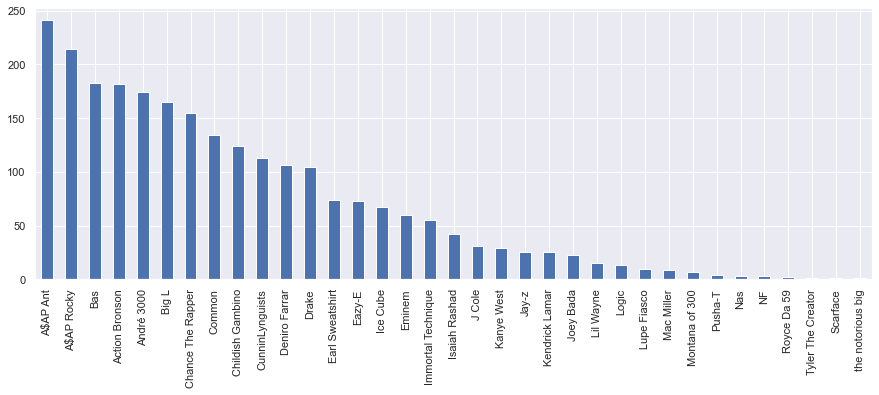

In [17]:
history.first_rapper.value_counts().plot(kind='bar',figsize=(15, 5), label="artists");

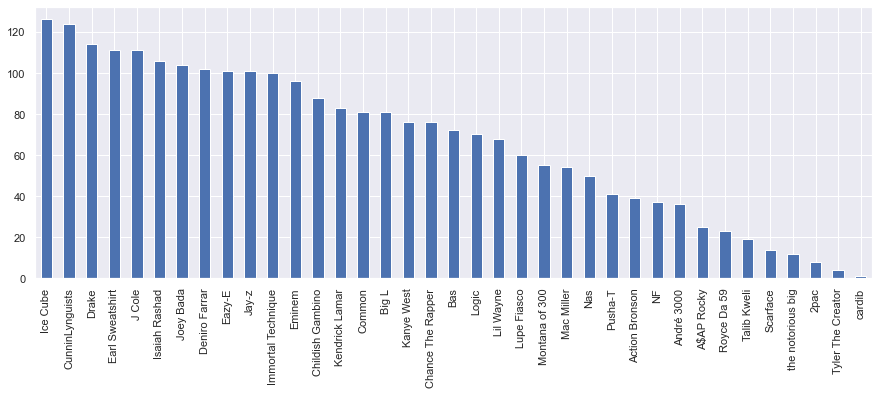

In [18]:
history.second_rapper.value_counts().plot(kind='bar',figsize=(15, 5), label="artists");

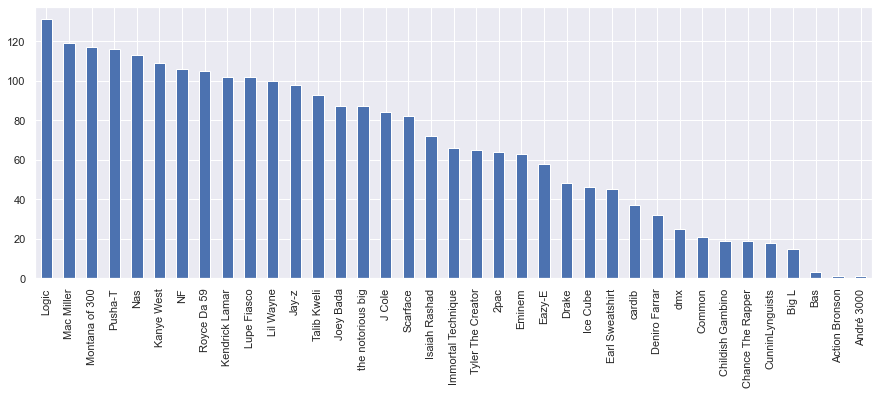

In [19]:
history.third_rapper.value_counts().plot(kind='bar',figsize=(15, 5), label="artists");

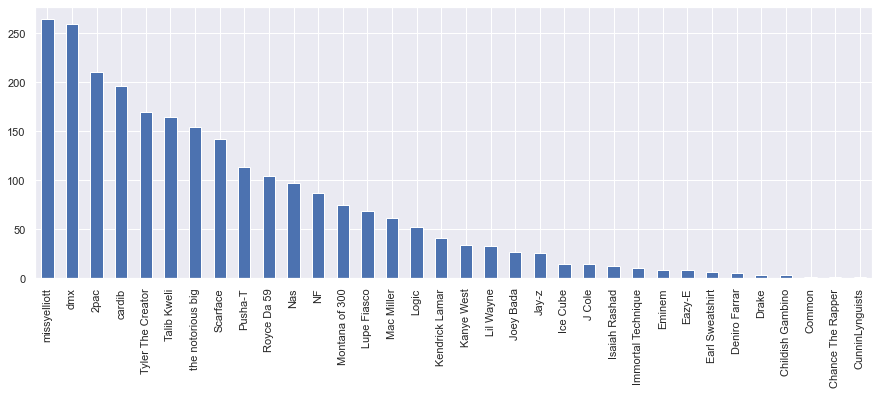

In [20]:
history.fourth_rapper.value_counts().plot(kind='bar',figsize=(15, 5), label="artists");

## Lets look around at what we have

Agains some of our instances of running that model encountered an issue that means they are not really benificail so we can eliminate them last time we eliminated anything below .48. This time we will get rid of anything below .1.

Some of the model results did not come in lets clear them out 

In [21]:
history = history[history['accuracy'] > .01] 
history = history[history['first_score'] > .01]
history = history[history['second_score'] > .01]
history = history[history['third_score'] > .01] 
history = history[history['fourth_score'] > .01]

In [22]:
history.head(1)

,accuracy,first_rapper,first_score,fourth_rapper,fourth_score,second_rapper,second_score,testing,third_rapper,third_score
0,0.708018,A$AP Ant,0.807143,Drake,0.582048,A$AP Rocky,0.577957,"A$AP Ant,A$AP Rocky,Action Bronson,Drake",Action Bronson,0.708018


In [23]:
history.describe()

,accuracy,first_score,fourth_score,second_score,third_score
count,2444.000000,2444.000000,2444.000000,2444.000000,2444.000000
mean,0.620541,0.689245,0.671517,0.630704,0.620541
std,0.090083,0.128994,0.159710,0.089128,0.090083
min,0.437500,0.445008,0.333333,0.448037,0.437500
25%,0.562538,0.595423,0.563709,0.571844,0.562538
50%,0.607038,0.652384,0.613108,0.618131,0.607038
75%,0.659774,0.769231,0.710115,0.672574,0.659774
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
#fig = px.scatter_matrix(history, dimensions=["first_score", "second_score", "third_score", "fourth_score"], color="accuracy")
#fig.show()
#fig1.write_html("./html/scatt_results1.html")
IFrame(src='./html/scatt_results1.html', width=900, height=500)

**Lets observe the distribution of the scores here to get a better idea.** 

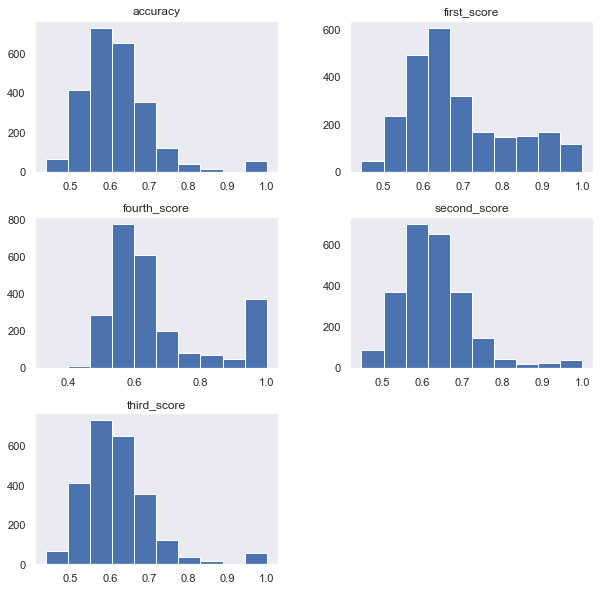

In [25]:
history.hist(figsize=(10,10), grid=False);

We have to Drop the Control Group--They are skewing our results.

In [26]:
drop_list=['cardib','dmx','2pac','missyelliott']
for each in drop_list:
    history.drop(history.loc[history['first_rapper']==each].index, inplace=True)
    history.drop(history.loc[history['second_rapper']==each].index, inplace=True)
    history.drop(history.loc[history['third_rapper']==each].index, inplace=True)
    history.drop(history.loc[history['fourth_rapper']==each].index, inplace=True)

In [27]:
history.describe()

,accuracy,first_score,fourth_score,second_score,third_score
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,0.583000,0.660944,0.582080,0.600433,0.583000
std,0.055179,0.129351,0.052612,0.077795,0.055179
min,0.445909,0.445008,0.444444,0.448037,0.445909
25%,0.543553,0.571817,0.544344,0.552482,0.543553
50%,0.579193,0.624796,0.581043,0.590254,0.579193
75%,0.616050,0.690523,0.615831,0.636860,0.616050
max,0.882353,1.000000,0.785950,1.000000,0.882353


In [55]:
#fig1 = px.scatter_matrix(history, dimensions=["first_score", "second_score", "third_score", "fourth_score"], color="accuracy")
#fig1.show()
#fig1.write_html("./html/scatt_results.html")
IFrame(src='./html/scatt_results.html', width=900, height=500)

Instead of trying to analyze these different classes seperately if our goal is to predict the distinction of artist to artist why not just combine them same way we did before? So in the next set we are going to do two things:

1. We are going to combine all the rappers and scores into one column 
2. We are going to confirm that all the samples we have are a unique combination of artists by turning the artist column into a list, sorting and seeing if we actually have duplicates. 

In [29]:
first=history[['testing','accuracy','first_rapper','first_score']].copy()
second=history[['testing','accuracy','second_rapper','second_score']].copy()
third=history[['testing','accuracy','third_rapper','third_score']].copy()
fourth=history[['testing','accuracy','fourth_rapper','fourth_score']].copy()

In [30]:
first.rename(columns={'first_rapper': 'artist', 'first_score': 'target_score'},inplace=True)
second.rename(columns={'second_rapper': 'artist', 'second_score': 'target_score'},inplace=True)
third.rename(columns={'third_rapper': 'artist', 'third_score': 'target_score'},inplace=True)
fourth.rename(columns={'fourth_rapper': 'artist', 'fourth_score': 'target_score'},inplace=True)

In [31]:
results=pd.concat([first,second,third,fourth],ignore_index=True)
results.shape

(6160, 4)

Now lets explore what we have: 

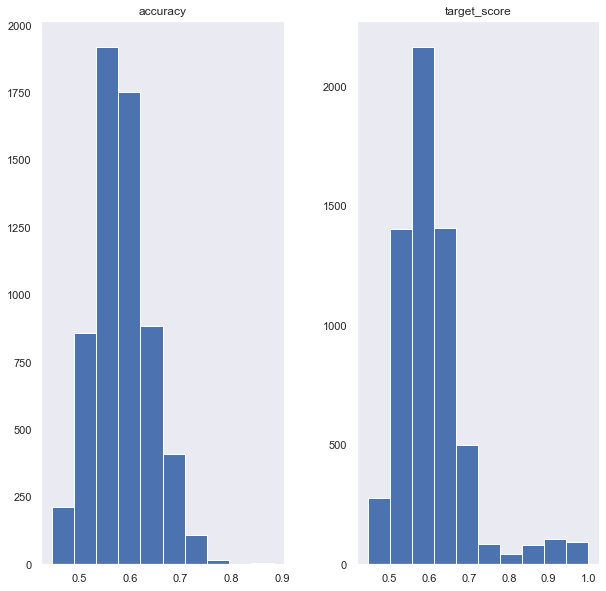

In [32]:
results.hist(figsize=(10,10), grid=False);

**If there are any duplicate expirements then we can drop them**

In [33]:
results['testy']=results["testing"].str.split(",", n = 3)
results= results.drop('testing', 1)
results['new'] = results.testy.sort_values()
results= results.drop('testy', 1)
results['new']=results.new.astype(str).str.replace('\[|\]|\'', '')
results=results.drop_duplicates(subset=['artist', 'new'], keep='last')
results.shape

(6160, 4)

## Lets Visualize what is taking place

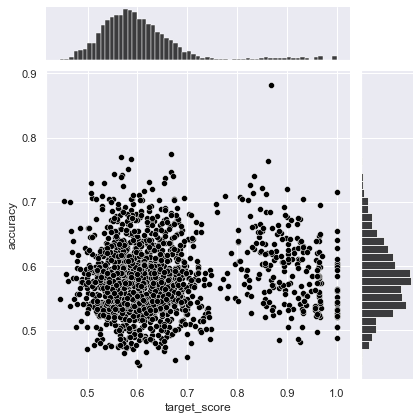

In [34]:
sns.jointplot(x=results['target_score'], y=history['accuracy'], kind="scatter", color="black");

In [35]:
results= results.drop('new', 1)
med_results=results.groupby("artist").median()
mean_results=results.groupby("artist").mean()

**Lets review the Mean results from our results**

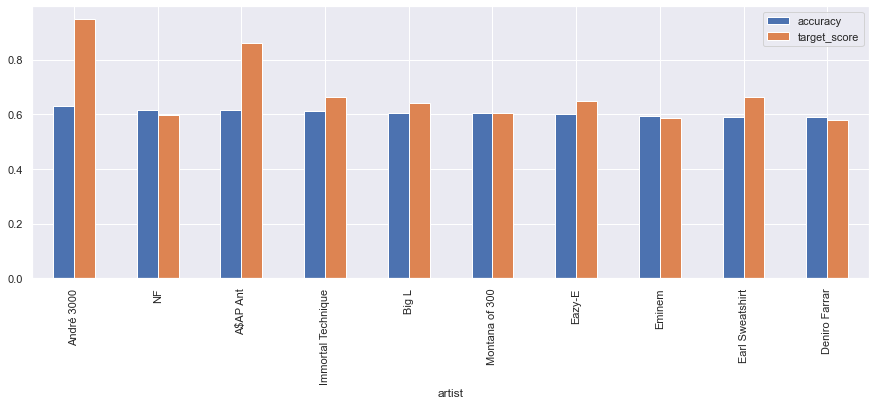

In [36]:
results.groupby("artist").mean().sort_values(['accuracy','target_score'],ascending=False).head(10).plot(kind='bar',figsize=(15, 5), label="artists");

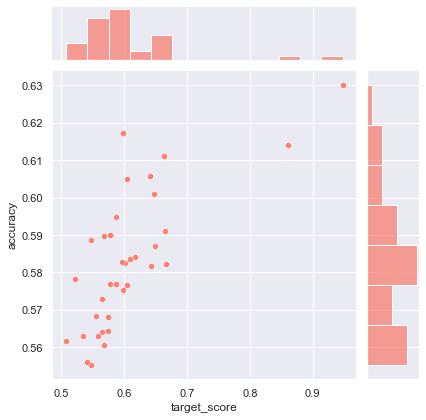

In [37]:
sns.jointplot(x=mean_results['target_score'], y=mean_results['accuracy'], kind="scatter", color="salmon");

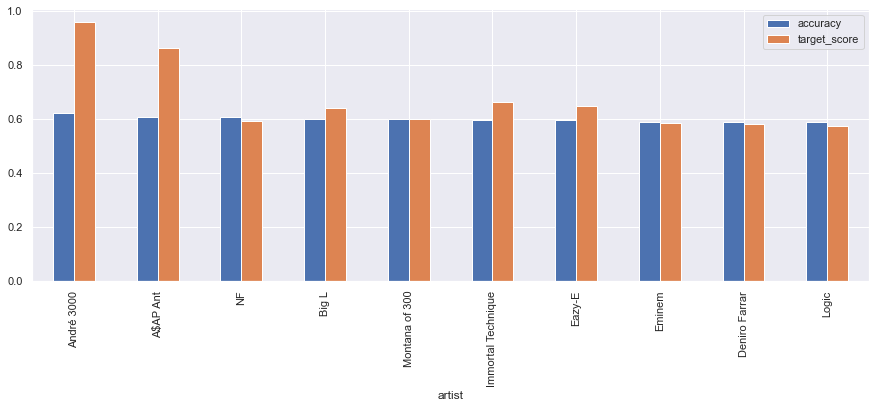

In [38]:
results.groupby("artist").median().sort_values(['accuracy','target_score'],ascending=False).head(10).plot(kind='bar',figsize=(15, 5), label="artists");

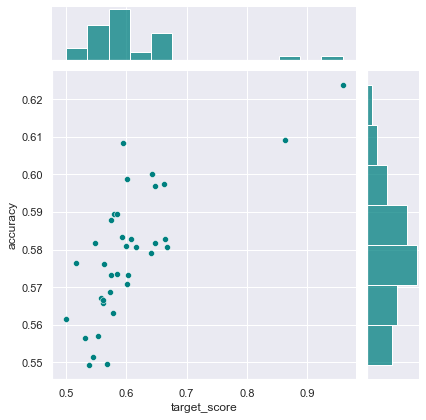

In [39]:
sns.jointplot(x=med_results['target_score'], y=med_results['accuracy'], kind="scatter", color="teal");

The Average Results

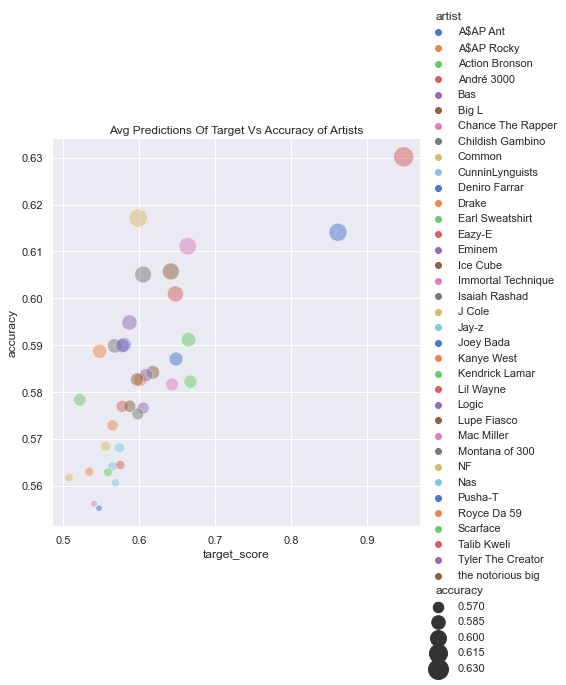

In [40]:
sns.relplot(x="target_score", y="accuracy", hue="artist", size="accuracy",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=mean_results);
plt.title("Avg Predictions Of Target Vs Accuracy of Artists", fontsize=12);

The Median Results

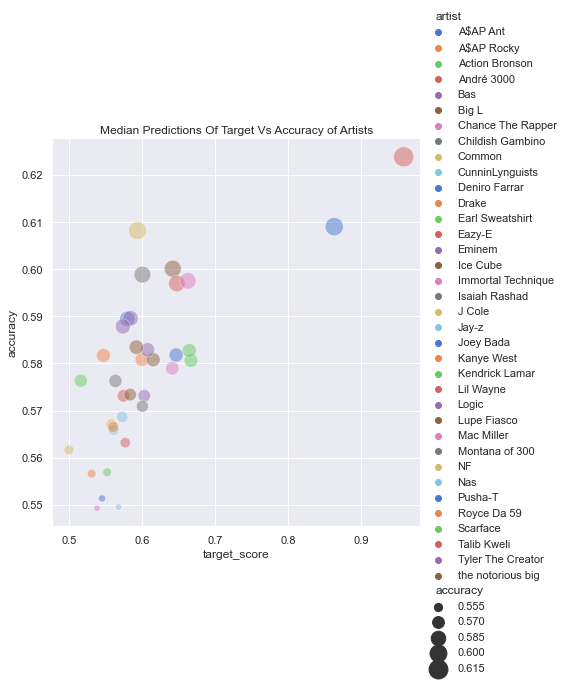

In [41]:
sns.relplot(x="target_score", y="accuracy", hue="artist", size="accuracy",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=med_results);
plt.title("Median Predictions Of Target Vs Accuracy of Artists", fontsize=12);

Total Results

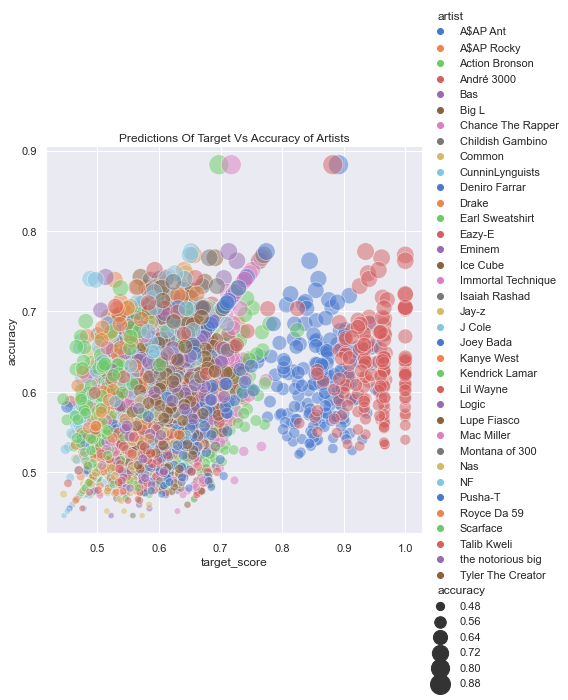

In [42]:
sns.relplot(x="target_score", y="accuracy", hue="artist", size="accuracy",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=results);
plt.title("Predictions Of Target Vs Accuracy of Artists", fontsize=12);

## Revisting ASAP Ant

In [43]:
ant=results[(results.artist== "A$AP Ant")]
ant.describe()

,accuracy,target_score
count,165.000000,165.000000
mean,0.614093,0.861427
std,0.055117,0.042595
min,0.522175,0.728477
25%,0.571217,0.830508
50%,0.609043,0.863309
75%,0.649682,0.893617
max,0.882353,0.959596


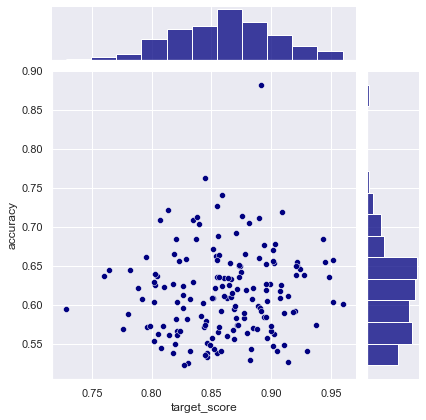

In [44]:
sns.jointplot(x=ant['target_score'], y=ant['accuracy'], kind="scatter", color="navy");

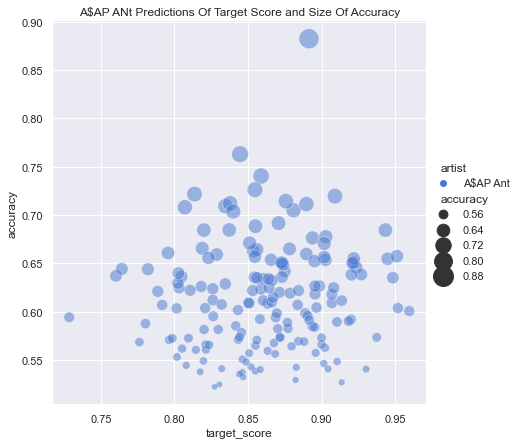

In [45]:
sns.relplot(x="target_score", y="accuracy", hue="artist", size="accuracy",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=ant);
plt.title("A$AP ANt Predictions Of Target Score and Size Of Accuracy", fontsize=12);

In [46]:
df_ant=pd.read_csv('./assets/averages.csv')

In [52]:
#fig=px.scatter(results, x="target_score", y="accuracy", color="artist", size="accuracy", size_max=10)
#fig.show() 
#fig.write_html("./html/mnb_results.html")
IFrame(src='./html/mnb_results.html', width=900, height=500)

## Lets Combine What we found out with our EDA

In looking through our second multi classification scenarios we can see some interesting takes on some of the details that have changed from the other the binary classification. 

The results of what seemed to be correlations are extremely silent here. 

In [48]:
combined_dfs=pd.merge(mean_results,df_ant, how="inner", on="artist")

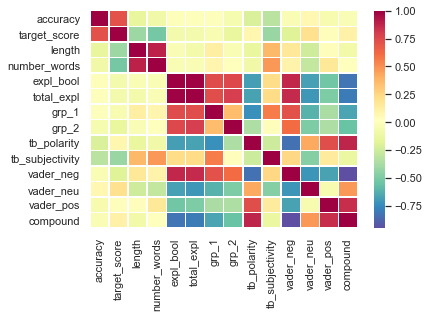

In [49]:
corr = combined_dfs.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=.5, cmap='Spectral_r');